# Feature-level SAE Transfer & Semantics Analysis

## Objective
Analyze how individual SAE (Sparse Autoencoder) features change under multimodal adaptation from a base LLM to its multimodal variant.

Supported model families:
- **Gemma/PaliGemma**: Gemma-2B base → PaliGemma multimodal
- **LLaMA/LLaVA**: LLaMA-2-7B base → LLaVA-1.5-7B multimodal

This experiment:
1. Loads pre-trained SAE weights (GemmaScope for Gemma, or trains from scratch for LLaMA)
2. Extracts hidden layer activations from both base and multimodal models
3. Identifies interpretable features and categorizes them as:
   - **Stable features**: Activate similarly across both models
   - **Shifted features**: Exist in both but with different activation patterns
   - **New features**: Only strongly active in the multimodal model (vision-specific)

In [1]:
# ==========================================
# Cell 1: Install Dependencies and Imports
# ==========================================
# Uncomment below if needed:
# %pip install sae-lens transformers torch matplotlib seaborn pandas tqdm datasets

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    AutoModelForCausalLM,
    AutoModelForImageTextToText,
    AutoTokenizer,
    AutoProcessor
)

from PIL import Image
from tqdm.auto import tqdm
from typing import Dict, List, Tuple, Optional
import os
import json
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

torch.set_grad_enabled(False)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB


## Configuration and Model Setup

Supported model families:
- **Gemma family**: Gemma-2B (base) + PaliGemma-3B (multimodal) with GemmaScope SAEs
- **LLaMA family**: LLaMA-2-7B (base) + LLaVA-1.5-7B (multimodal) with trained SAEs

Set `MODEL_FAMILY` in the next cell to switch between families.

In [2]:
# ==========================================
# Cell 2: Configuration
# ==========================================

# ============== MODEL FAMILY SWITCH ==============
# Choose which model family to analyze:
# - "gemma": Gemma-2B base + PaliGemma multimodal
# - "llama": LLaMA-3.2 base + LLaVA multimodal
MODEL_FAMILY = "gemma"  # Change to "llama" for LLaMA/LLaVA analysis
# =================================================

# Model configurations by family
MODEL_CONFIGS = {
    "gemma": {
        "base_model": "google/gemma-2-2b",
        "multimodal_model": "google/paligemma2-3b-pt-224",
        "sae_release": "gemma-scope-2b-pt-res-canonical",
        "num_layers": 26,  # Gemma-2-2B has 26 layers
        "hidden_size": 2304,
        "recommended_layer": 10,
    },
    "llama": {
        # IMPORTANT: Base and multimodal models must have matching hidden dimensions!
        # LLaVA-1.5-7B uses Vicuna-7B (LLaMA-2-7B based) with hidden_size=4096
        # So we use LLaMA-2-7B as the base model for fair comparison
        "base_model": "meta-llama/Llama-2-7b-hf",
        "multimodal_model": "llava-hf/llava-1.5-7b-hf",
        "sae_release": None,  # No public SAE for LLaMA yet - will train from scratch
        "num_layers": 32,  # LLaMA-2-7B has 32 layers
        "hidden_size": 4096,
        "recommended_layer": 16,
    },
}

# Get current model config
CURRENT_CONFIG = MODEL_CONFIGS[MODEL_FAMILY]

# Model names (resolved from config)
BASE_MODEL_NAME = CURRENT_CONFIG["base_model"]
MULTIMODAL_MODEL_NAME = CURRENT_CONFIG["multimodal_model"]

# Device configuration
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
print(f"\n{'='*50}")
print(f"MODEL FAMILY: {MODEL_FAMILY.upper()}")
print(f"{'='*50}")
print(f"Base model: {BASE_MODEL_NAME}")
print(f"Multimodal model: {MULTIMODAL_MODEL_NAME}")
print(f"{'='*50}\n")

# SAE configuration - we'll extract from a middle layer
# Layer selection depends on model architecture
TARGET_LAYER = CURRENT_CONFIG["recommended_layer"]
SAE_HIDDEN_DIM = 16384  # Typical SAE expansion factor of 8x

# Analysis configuration
NUM_FEATURES_TO_ANALYZE = 100  # Number of top features to analyze
TOP_K_ACTIVATIONS = 20  # Top activations per feature to examine

Using device: cuda:0

MODEL FAMILY: GEMMA
Base model: google/gemma-2-2b
Multimodal model: google/paligemma2-3b-pt-224



## Sparse Autoencoder Implementation

We implement a simple SAE class that can:
1. Train on model activations
2. Encode activations to sparse feature representations  
3. Decode back to original space

The SAE uses a ReLU activation for sparsity and includes L1 regularization.

In [3]:
# ==========================================
# Cell 3: Sparse Autoencoder Implementation
# ==========================================

class SparseAutoencoder(nn.Module):
    """
    Sparse Autoencoder for learning interpretable features from model activations.

    Architecture:
    - Encoder: Linear(d_model -> d_sae) + ReLU for sparsity
    - Decoder: Linear(d_sae -> d_model) with tied weights optional
    """

    def __init__(
        self,
        d_model: int,
        d_sae: int,
        dtype: torch.dtype = torch.float32,
        device: torch.device = None
    ):
        super().__init__()
        self.d_model = d_model
        self.d_sae = d_sae
        self.device = device or torch.device("cpu")

        # Encoder: projects activations to sparse feature space
        self.W_enc = nn.Parameter(torch.empty(d_model, d_sae, dtype=dtype, device=device))
        self.b_enc = nn.Parameter(torch.zeros(d_sae, dtype=dtype, device=device))

        # Decoder: reconstructs original activations
        self.W_dec = nn.Parameter(torch.empty(d_sae, d_model, dtype=dtype, device=device))
        self.b_dec = nn.Parameter(torch.zeros(d_model, dtype=dtype, device=device))

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize with Kaiming normal for encoder, transpose for decoder"""
        nn.init.kaiming_normal_(self.W_enc, nonlinearity='relu')
        # Initialize decoder as transpose of encoder (tied initialization)
        self.W_dec.data = self.W_enc.data.T.clone()

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """
        Encode activations to sparse feature space.

        Args:
            x: Activation tensor of shape [..., d_model]
        Returns:
            Sparse feature tensor of shape [..., d_sae]
        """
        # Pre-encoder bias subtraction (center activations)
        x_centered = x - self.b_dec
        # Linear projection + ReLU for sparsity
        return F.relu(x_centered @ self.W_enc + self.b_enc)

    def decode(self, features: torch.Tensor) -> torch.Tensor:
        """
        Decode sparse features back to activation space.

        Args:
            features: Sparse feature tensor of shape [..., d_sae]
        Returns:
            Reconstructed activation tensor of shape [..., d_model]
        """
        return features @ self.W_dec + self.b_dec

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Full forward pass: encode then decode.

        Returns:
            - reconstructed: Reconstructed activations
            - features: Sparse feature activations
        """
        features = self.encode(x)
        reconstructed = self.decode(features)
        return reconstructed, features

    def get_feature_activations(self, x: torch.Tensor) -> torch.Tensor:
        """Get just the feature activations for analysis."""
        return self.encode(x)

print("SparseAutoencoder class defined successfully!")

SparseAutoencoder class defined successfully!


## Load SAE Weights

For Gemma family: GemmaScope provides pre-trained SAEs. We'll download and load these weights.
For LLaMA family: No public SAEs available yet, so we train a simple SAE on collected activations.

In [5]:
# ==========================================
# Cell 4: Load GemmaScope SAE using sae-lens
# ==========================================
%pip install sae-lens
from sae_lens import SAE  # pip install sae-lens

def load_gemmascope_sae(layer_idx: int = 10, width: str = "16k", device: torch.device = DEVICE):
    """
    Load GemmaScope SAE weights using sae-lens library.

    GemmaScope SAEs are available at: gemma-scope-2b-pt-res-canonical
    Format: layer_{layer_idx}/width_{width}/canonical
    """
    try:
        sae_id = f"layer_{layer_idx}/width_{width}/canonical"
        print(f"Loading GemmaScope SAE: {sae_id}")

        sae, cfg_dict, sparsity = SAE.from_pretrained(
            release="gemma-scope-2b-pt-res-canonical",
            sae_id=sae_id,
            device=str(device),
        )

        print(f"  Loaded GemmaScope SAE for layer {layer_idx}")
        print(f"  d_model (d_in): {sae.cfg.d_in}, d_sae: {sae.cfg.d_sae}")
        print(f"  Sparsity (L0): {sparsity:.2f}" if sparsity else "  Sparsity: N/A")

        return sae

    except Exception as e:
        print(f"Could not load GemmaScope SAE: {e}")
        print("Falling back to training SAE from scratch...")
        return None


def load_pretrained_sae(
    model_family: str,
    layer_idx: int,
    device: torch.device = DEVICE
) -> Optional[SAE]:
    """
    Load a pretrained SAE for the specified model family.

    Args:
        model_family: "gemma" or "llama"
        layer_idx: Target layer index
        device: Torch device

    Returns:
        SAE object or None if not available
    """
    if model_family == "gemma":
        return load_gemmascope_sae(layer_idx=layer_idx, device=device)
    elif model_family == "llama":
        # Try to load LLaMA SAEs if available
        # Currently no public release - check for potential sources
        try:
            # Check if there's a local SAE or known release
            # SAE-lens may support LLaMA SAEs in the future
            print(f"Attempting to load LLaMA SAE for layer {layer_idx}...")

            # Try potential LLaMA SAE releases (update as they become available)
            llama_sae_releases = [
                "llama-scope-1b-res",  # Hypothetical future release
            ]

            for release in llama_sae_releases:
                try:
                    sae_id = f"layer_{layer_idx}/width_16k/canonical"
                    sae, cfg_dict, sparsity = SAE.from_pretrained(
                        release=release,
                        sae_id=sae_id,
                        device=str(device),
                    )
                    print(f"  Loaded LLaMA SAE from {release}")
                    return sae
                except:
                    continue

            print("  No pretrained LLaMA SAE available.")
            print("  Will train SAE from scratch on LLaMA activations.")
            return None

        except Exception as e:
            print(f"  Could not load LLaMA SAE: {e}")
            return None
    else:
        print(f"Unknown model family: {model_family}")
        return None


def train_simple_sae(
    activations: torch.Tensor,
    d_model: int,
    d_sae: int,
    num_epochs: int = 50,
    batch_size: int = 256,
    lr: float = 1e-3,
    l1_coeff: float = 5e-4,
    device: torch.device = DEVICE
):
    """
    Train a simple SAE on provided activations (fallback if pretrained unavailable).

    Args:
        activations: Tensor of shape [N, d_model]
        d_model: Model hidden dimension
        d_sae: SAE hidden dimension (typically 8x d_model)
        num_epochs: Training epochs
        batch_size: Batch size
        lr: Learning rate
        l1_coeff: L1 sparsity regularization coefficient
    """
    sae = SparseAutoencoder(d_model, d_sae, device=device).to(device)
    optimizer = torch.optim.Adam(sae.parameters(), lr=lr)

    # Prepare data
    activations = activations.to(device).float()
    dataset = torch.utils.data.TensorDataset(activations)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Enable gradients for training
    for param in sae.parameters():
        param.requires_grad = True

    losses = []
    with torch.enable_grad():
        for epoch in tqdm(range(num_epochs), desc="Training SAE"):
            epoch_loss = 0
            for batch in dataloader:
                x = batch[0]
                optimizer.zero_grad()

                # Forward pass
                reconstructed, features = sae(x)

                # Reconstruction loss (MSE)
                recon_loss = F.mse_loss(reconstructed, x)

                # Sparsity loss (L1 on feature activations)
                l1_loss = l1_coeff * features.abs().mean()

                # Total loss
                loss = recon_loss + l1_loss
                loss.backward()
                optimizer.step()

                # Normalize decoder weights (important for SAE stability)
                with torch.no_grad():
                    sae.W_dec.data = F.normalize(sae.W_dec.data, dim=1)

                epoch_loss += loss.item()

            losses.append(epoch_loss / len(dataloader))

    # Disable gradients after training
    for param in sae.parameters():
        param.requires_grad = False

    print(f"Final loss: {losses[-1]:.4f}")
    return sae, losses


print(f"SAE loading functions defined for {MODEL_FAMILY.upper()} family!")
print(f"  Pretrained SAE available: {CURRENT_CONFIG['sae_release'] is not None}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.1/145.1 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.5/220.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.0/192.0 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 137.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.7/273.7 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.6/236.6 kB 24.5 MB/s eta 0:00:00
  Created wheel for transformers-stream-generator: filename=transformers_stream_generator-0.0.5-py3-none-any.whl siz

SAE loading functions defined for GEMMA family!
  Pretrained SAE available: True


## Load Models: Gemma-base and PaliGemma

We load both models to extract and compare activations at the same layer.

In [6]:
# ==========================================
# Cell 5: Load Models
# ==========================================

def load_gemma_models():
    """Load Gemma-2B base and PaliGemma multimodal models."""
    print("Loading Gemma-2B base model...")
    base_model = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_NAME,
        torch_dtype=torch.bfloat16,
        device_map=DEVICE,
    )
    base_tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
    print(f"  Loaded {BASE_MODEL_NAME}")
    print(f"  Number of layers: {base_model.config.num_hidden_layers}")
    print(f"  Hidden size: {base_model.config.hidden_size}")

    print("\nLoading PaliGemma multimodal model...")
    mm_model = AutoModelForImageTextToText.from_pretrained(
        MULTIMODAL_MODEL_NAME,
        torch_dtype=torch.bfloat16,
        device_map=DEVICE,
    )
    mm_processor = AutoProcessor.from_pretrained(MULTIMODAL_MODEL_NAME)
    mm_tokenizer = AutoTokenizer.from_pretrained(MULTIMODAL_MODEL_NAME)
    print(f"  Loaded {MULTIMODAL_MODEL_NAME}")
    print(f"  Number of layers: {mm_model.language_model.config.num_hidden_layers}")
    print(f"  Hidden size: {mm_model.language_model.config.hidden_size}")

    return base_model, base_tokenizer, mm_model, mm_processor, mm_tokenizer


def load_llama_models():
    """Load LLaMA base and LLaVA multimodal models."""
    from transformers import LlavaForConditionalGeneration, LlavaProcessor

    print("Loading LLaMA base model...")
    base_model = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL_NAME,
        torch_dtype=torch.bfloat16,
        device_map=DEVICE,
    )
    base_tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
    if base_tokenizer.pad_token is None:
        base_tokenizer.pad_token = base_tokenizer.eos_token
    print(f"  Loaded {BASE_MODEL_NAME}")
    print(f"  Number of layers: {base_model.config.num_hidden_layers}")
    print(f"  Hidden size: {base_model.config.hidden_size}")

    print("\nLoading LLaVA multimodal model...")
    mm_model = LlavaForConditionalGeneration.from_pretrained(
        MULTIMODAL_MODEL_NAME,
        torch_dtype=torch.bfloat16,
        device_map=DEVICE,
    )
    mm_processor = LlavaProcessor.from_pretrained(MULTIMODAL_MODEL_NAME)
    mm_tokenizer = mm_processor.tokenizer
    if mm_tokenizer.pad_token is None:
        mm_tokenizer.pad_token = mm_tokenizer.eos_token
    print(f"  Loaded {MULTIMODAL_MODEL_NAME}")
    print(f"  Number of layers: {mm_model.language_model.config.num_hidden_layers}")
    print(f"  Hidden size: {mm_model.language_model.config.hidden_size}")

    return base_model, base_tokenizer, mm_model, mm_processor, mm_tokenizer


# Load models based on selected family
if MODEL_FAMILY == "gemma":
    base_model, base_tokenizer, mm_model, mm_processor, mm_tokenizer = load_gemma_models()
elif MODEL_FAMILY == "llama":
    base_model, base_tokenizer, mm_model, mm_processor, mm_tokenizer = load_llama_models()
else:
    raise ValueError(f"Unknown model family: {MODEL_FAMILY}. Choose 'gemma' or 'llama'.")

# Store references with generic names for downstream compatibility
# (Legacy variable names for backward compatibility)
if MODEL_FAMILY == "gemma":
    gemma_model = base_model
    gemma_tokenizer = base_tokenizer
    paligemma_model = mm_model
    paligemma_processor = mm_processor
    paligemma_tokenizer = mm_tokenizer
else:
    # For LLaMA family, use the same generic names
    gemma_model = base_model
    gemma_tokenizer = base_tokenizer
    paligemma_model = mm_model
    paligemma_processor = mm_processor
    paligemma_tokenizer = mm_tokenizer

Loading Gemma-2B base model...


config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

  Loaded google/gemma-2-2b
  Number of layers: 26
  Hidden size: 2304

Loading PaliGemma multimodal model...


config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/75.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/424 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

  Loaded google/paligemma2-3b-pt-224
  Number of layers: 26
  Hidden size: 2304


## Activation Extraction Hooks

We use forward hooks to capture hidden state activations at a specific layer.
This allows us to extract activations without modifying the model code.

In [7]:
# ==========================================
# Cell 6: Activation Extraction Class
# ==========================================

class ActivationExtractor:
    """
    Extracts hidden layer activations from transformer models using forward hooks.
    Works with both standard LLMs and multimodal models across different families.

    Supported model types:
    - "gemma": Base Gemma model (AutoModelForCausalLM)
    - "paligemma": Full PaliGemma model (AutoModelForImageTextToText)
    - "paligemma_lm": PaliGemma's language model directly (Gemma2Model)
    - "llama": Base LLaMA model (AutoModelForCausalLM)
    - "llava": Full LLaVA model (LlavaForConditionalGeneration)
    - "llava_lm": LLaVA's language model directly
    """

    def __init__(self, model, target_layer: int, model_type: str = "gemma"):
        """
        Args:
            model: The transformer model
            target_layer: Which layer to extract activations from
            model_type: One of the supported model types
        """
        self.model = model
        self.target_layer = target_layer
        self.model_type = model_type
        self.activations = []
        self.hook_handle = None

    def _get_target_module(self):
        """Get the module to attach the hook to based on model architecture."""
        if self.model_type == "gemma":
            # AutoModelForCausalLM (Gemma): model.model.layers[i]
            return self.model.model.layers[self.target_layer]
        elif self.model_type == "paligemma":
            # AutoModelForImageTextToText: language_model is Gemma2Model with layers directly
            return self.model.language_model.layers[self.target_layer]
        elif self.model_type == "paligemma_lm":
            # Direct Gemma2Model: layers are directly accessible
            return self.model.layers[self.target_layer]
        elif self.model_type == "llama":
            # AutoModelForCausalLM (LLaMA): model.model.layers[i]
            return self.model.model.layers[self.target_layer]
        elif self.model_type == "llava":
            # LlavaForConditionalGeneration: language_model may be LlamaForCausalLM or LlamaModel
            lm = self.model.language_model
            if hasattr(lm, 'model') and hasattr(lm.model, 'layers'):
                # language_model is LlamaForCausalLM
                return lm.model.layers[self.target_layer]
            elif hasattr(lm, 'layers'):
                # language_model is LlamaModel directly
                return lm.layers[self.target_layer]
            else:
                raise ValueError(f"Cannot find layers in LLaVA language model: {type(lm)}")
        elif self.model_type == "llava_lm":
            # LLaVA's language_model - handle both LlamaForCausalLM and LlamaModel
            # Some versions return LlamaForCausalLM (with .model.layers)
            # Others return LlamaModel directly (with .layers)
            if hasattr(self.model, 'model') and hasattr(self.model.model, 'layers'):
                # self.model is LlamaForCausalLM
                return self.model.model.layers[self.target_layer]
            elif hasattr(self.model, 'layers'):
                # self.model is LlamaModel directly
                return self.model.layers[self.target_layer]
            else:
                raise ValueError(f"Cannot find layers in LLaVA language model: {type(self.model)}")
        else:
            raise ValueError(f"Unknown model type: {self.model_type}")

    def _hook_fn(self, module, input, output):
        """Hook function to capture activations."""
        # Output is typically (hidden_states, ...) or just hidden_states
        if isinstance(output, tuple):
            hidden_states = output[0]
        else:
            hidden_states = output
        # Flatten batch and sequence dims to [num_tokens, d_model]
        # This handles variable sequence lengths across prompts
        flat_activations = hidden_states.detach().cpu().float().reshape(-1, hidden_states.shape[-1])
        self.activations.append(flat_activations)

    def attach_hook(self):
        """Attach the forward hook."""
        target_module = self._get_target_module()
        self.hook_handle = target_module.register_forward_hook(self._hook_fn)

    def remove_hook(self):
        """Remove the forward hook."""
        if self.hook_handle:
            self.hook_handle.remove()
            self.hook_handle = None

    def clear_activations(self):
        """Clear stored activations."""
        self.activations = []

    def get_activations(self) -> torch.Tensor:
        """Get all collected activations as a single tensor of shape [total_tokens, d_model]."""
        if not self.activations:
            return None
        return torch.cat(self.activations, dim=0)


def get_model_types_for_family(model_family: str) -> Dict[str, str]:
    """Return the appropriate model type strings for each model family."""
    if model_family == "gemma":
        return {
            "base": "gemma",
            "mm_full": "paligemma",
            "mm_lm": "paligemma_lm",
        }
    elif model_family == "llama":
        return {
            "base": "llama",
            "mm_full": "llava",
            "mm_lm": "llava_lm",
        }
    else:
        raise ValueError(f"Unknown model family: {model_family}")


def extract_text_activations(
    text_prompts: List[str],
    model,
    tokenizer,
    extractor: ActivationExtractor,
) -> Tuple[torch.Tensor, List[str]]:
    """
    Extract activations for text-only prompts from a language model.

    Returns:
        activations: Tensor of shape [total_tokens, d_model]
        tokens: List of token strings corresponding to each activation
    """
    extractor.clear_activations()
    extractor.attach_hook()

    all_tokens = []

    with torch.no_grad():
        for prompt in tqdm(text_prompts, desc="Extracting text activations"):
            inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
            model(**inputs)

            # Decode tokens for reference
            token_ids = inputs.input_ids[0].tolist()
            tokens = [tokenizer.decode([tid]) for tid in token_ids]
            all_tokens.extend(tokens)

    extractor.remove_hook()
    activations = extractor.get_activations()

    return activations, all_tokens


def extract_image_text_activations(
    image_text_pairs: List[Tuple[Image.Image, str]],
    model,
    processor,
    extractor: ActivationExtractor,
    model_family: str = "gemma",
) -> Tuple[torch.Tensor, List[Dict]]:
    """
    Extract activations for image+text prompts from multimodal models.

    Returns:
        activations: Tensor of shape [total_tokens, d_model]
        token_info: List of dicts with token info (is_image, token_str, etc.)
    """
    extractor.clear_activations()
    extractor.attach_hook()

    all_token_info = []

    with torch.no_grad():
        for image, text in tqdm(image_text_pairs, desc="Extracting multimodal activations"):
            # Format prompt based on model family
            if model_family == "gemma":
                prompt = f"<image>{text}" if text else "<image>"
                inputs = processor(text=prompt, images=image, return_tensors="pt").to(DEVICE)
            elif model_family == "llama":
                # LLaVA uses different prompt format
                prompt = f"USER: <image>\n{text}\nASSISTANT:" if text else "USER: <image>\nDescribe this image.\nASSISTANT:"
                inputs = processor(text=prompt, images=image, return_tensors="pt").to(DEVICE)
            else:
                raise ValueError(f"Unknown model family: {model_family}")

            model(**inputs)

            # Track which tokens are image vs text
            # Image token count varies by model
            seq_len = inputs.input_ids.shape[1]
            num_image_tokens = 256 if model_family == "gemma" else 576  # LLaVA uses 576 patches

            for i in range(seq_len):
                all_token_info.append({
                    "is_image": i < num_image_tokens,
                    "token_id": inputs.input_ids[0, i].item() if i < inputs.input_ids.shape[1] else -1,
                })

    extractor.remove_hook()
    activations = extractor.get_activations()

    return activations, all_token_info


# Get model types for current family
MODEL_TYPES = get_model_types_for_family(MODEL_FAMILY)
print(f"Activation extraction configured for {MODEL_FAMILY.upper()} family")
print(f"  Base model type: {MODEL_TYPES['base']}")
print(f"  Multimodal full type: {MODEL_TYPES['mm_full']}")
print(f"  Multimodal LM type: {MODEL_TYPES['mm_lm']}")

Activation extraction configured for GEMMA family
  Base model type: gemma
  Multimodal full type: paligemma
  Multimodal LM type: paligemma_lm


## Test Prompts for Feature Analysis

We'll use a diverse set of prompts covering different semantic categories to identify interpretable features.

In [10]:
# ==========================================
# Cell 7: Define Test Prompts and Images
# ==========================================

# Diverse text prompts to probe different semantic features
TEXT_PROMPTS = [
    # Numbers and counting
    "The answer is 42.",
    "There are 3 apples and 5 oranges.",
    "1, 2, 3, 4, 5, 6, 7, 8, 9, 10",

    # Colors
    "The red ball bounced across the green grass.",
    "She wore a beautiful blue dress to the party.",
    "The yellow sun set behind the purple mountains.",

    # Animals
    "The dog chased the cat around the garden.",
    "A lion hunts zebras on the African savanna.",
    "The elephant's trunk can hold gallons of water.",

    # Spatial relationships
    "The book is on top of the table.",
    "The cat is sitting under the chair.",
    "The ball rolled between the two posts.",

    # Actions/verbs
    "She ran quickly down the stairs.",
    "He carefully opened the ancient door.",
    "The bird flew gracefully through the sky.",

    # Objects
    "The computer screen displayed an error message.",
    "The car drove down the highway at high speed.",
    "The camera captured the beautiful sunset.",

    # Abstract concepts
    "Love is patient, love is kind.",
    "The theory of relativity changed physics forever.",
    "Democracy requires active citizen participation.",

    # Code-related
    "def hello_world(): print('Hello!')",
    "for i in range(10): sum += i",
    "if x > 0: return True else: return False",
]

# Load LLaVA-Bench-In-The-Wild dataset from Hugging Face
def load_llava_bench_wild() -> List[Tuple[Image.Image, str]]:
    """
    Load sample images from LLaVA-Bench-In-The-Wild dataset.

    This dataset contains 60 diverse images with questions covering:
    - Conversational (conv)
    - Detailed description (detail)
    - Complex reasoning (complex)

    Returns:
        List of (image, question) tuples for multimodal testing
    """
    from datasets import load_dataset

    print("Loading LLaVA-Bench-In-The-Wild dataset from Hugging Face...")

    try:
        dataset = load_dataset("lmms-lab/llava-bench-in-the-wild", split="train")
        print(f"  Loaded dataset with {len(dataset)} examples")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        print("Attempting to load with trust_remote_code=True...")
        dataset = load_dataset("lmms-lab/llava-bench-in-the-wild", split="train", trust_remote_code=True)

    image_text_pairs = []
    seen_image_names = set()  # Track unique images by filename to avoid duplicates

    # Get unique images with their questions
    for idx, item in enumerate(dataset):
        # Use the image filename or index as identifier
        image_name = item.get('image_id', item.get('img_id', str(idx)))

        # If image_name is not a string (could be the image itself), use index
        if not isinstance(image_name, str):
            image_name = str(idx)

        # Skip if we've already seen this image (dataset has multiple questions per image)
        if image_name in seen_image_names:
            continue
        seen_image_names.add(image_name)

        # Get the image
        if 'image' in item and hasattr(item['image'], 'convert'):
            # Image is already a PIL Image
            img = item['image'].convert("RGB")
        else:
            print(f"  Skipping item {idx} without proper image")
            continue

        # Resize to standard size
        img = img.resize((224, 224))

        # Get question text
        question = item.get('question', 'Describe this image.')

        image_text_pairs.append((img, question))

        # Limit to ~20 unique images for efficiency
        if len(image_text_pairs) >= 20:
            break

    print(f"  Loaded {len(image_text_pairs)} unique image-question pairs from LLaVA-Bench-Wild")

    # Show category distribution
    categories = {}
    for item in dataset:
        cat = item.get('category', 'unknown')
        categories[cat] = categories.get(cat, 0) + 1
    print(f"  Dataset categories: {categories}")

    return image_text_pairs


def get_sample_images() -> List[Tuple[Image.Image, str]]:
    """Load sample images for multimodal testing."""
    return load_llava_bench_wild()


print(f"Defined {len(TEXT_PROMPTS)} text prompts for analysis")

Defined 24 text prompts for analysis


## Extract Activations and Train/Load SAE

Now we extract activations from both models and prepare the SAE for analysis.

In [11]:
# ==========================================
# Cell 8: Extract Activations from Both Models
# ==========================================

# Create extractors for both models using family-appropriate model types
base_extractor = ActivationExtractor(base_model, TARGET_LAYER, model_type=MODEL_TYPES["base"])

# For text-only extraction from multimodal model's language component
if MODEL_FAMILY == "gemma":
    # PaliGemma: language_model is directly a Gemma2Model
    mm_text_extractor = ActivationExtractor(
        mm_model.language_model, TARGET_LAYER, model_type=MODEL_TYPES["mm_lm"]
    )
elif MODEL_FAMILY == "llama":
    # LLaVA: language_model is a LlamaForCausalLM, need to access its layers
    mm_text_extractor = ActivationExtractor(
        mm_model.language_model, TARGET_LAYER, model_type=MODEL_TYPES["mm_lm"]
    )

# For full multimodal extraction with images
mm_full_extractor = ActivationExtractor(mm_model, TARGET_LAYER, model_type=MODEL_TYPES["mm_full"])

# Extract text activations from base model
print(f"Extracting activations from {BASE_MODEL_NAME}...")
base_text_acts, base_tokens = extract_text_activations(
    TEXT_PROMPTS, base_model, base_tokenizer, base_extractor
)
print(f"  Base model text activations shape: {base_text_acts.shape}")

# Extract text activations from multimodal model (text-only, for fair comparison)
print(f"\nExtracting text activations from {MULTIMODAL_MODEL_NAME}...")
mm_text_tokens = []

mm_text_extractor.clear_activations()
mm_text_extractor.attach_hook()

for prompt in tqdm(TEXT_PROMPTS, desc="Extracting multimodal model text activations"):
    # For text-only inputs, use the language model directly
    inputs = mm_tokenizer(prompt, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        if MODEL_FAMILY == "gemma":
            mm_model.language_model(**inputs)
        elif MODEL_FAMILY == "llama":
            mm_model.language_model(**inputs)

    token_ids = inputs.input_ids[0].tolist()
    tokens = [mm_tokenizer.decode([tid]) for tid in token_ids]
    mm_text_tokens.extend(tokens)

mm_text_extractor.remove_hook()
mm_text_acts = mm_text_extractor.get_activations()
print(f"  Multimodal model text activations shape: {mm_text_acts.shape}")

# Extract multimodal activations from multimodal model
print(f"\nExtracting multimodal (image+text) activations from {MULTIMODAL_MODEL_NAME}...")
image_text_pairs = get_sample_images()
mm_full_acts, mm_full_info = extract_image_text_activations(
    image_text_pairs, mm_model, mm_processor, mm_full_extractor, model_family=MODEL_FAMILY
)
print(f"  Multimodal activations shape: {mm_full_acts.shape}")

# Create legacy variable aliases for backward compatibility with remaining cells
gemma_text_acts = base_text_acts
gemma_tokens = base_tokens
paligemma_text_acts = mm_text_acts
paligemma_text_tokens = mm_text_tokens
paligemma_mm_acts = mm_full_acts
paligemma_mm_info = mm_full_info

Extracting activations from google/gemma-2-2b...


Extracting text activations:   0%|          | 0/24 [00:00<?, ?it/s]

  Base model text activations shape: torch.Size([255, 2304])

Extracting text activations from google/paligemma2-3b-pt-224...


Extracting multimodal model text activations:   0%|          | 0/24 [00:00<?, ?it/s]

  Multimodal model text activations shape: torch.Size([231, 2304])

Extracting multimodal (image+text) activations from google/paligemma2-3b-pt-224...
Loading LLaVA-Bench-In-The-Wild dataset from Hugging Face...
  Loaded dataset with 60 examples
  Loaded 20 unique image-question pairs from LLaVA-Bench-Wild
  Dataset categories: {'conv': 17, 'detail': 15, 'complex': 28}


Extracting multimodal activations:   0%|          | 0/20 [00:00<?, ?it/s]

  Multimodal activations shape: torch.Size([5344, 2304])


In [12]:
# ==========================================
# Cell 9: Load or Train SAE
# ==========================================

# Try to load pretrained SAE for current model family
sae = load_pretrained_sae(MODEL_FAMILY, layer_idx=TARGET_LAYER, device=DEVICE)

# If pretrained SAE not available, train on base model activations
if sae is None:
    print(f"\nTraining SAE on {MODEL_FAMILY.upper()} base model activations...")
    d_model = base_text_acts.shape[-1]
    d_sae = d_model * 8  # 8x expansion factor

    # Reshape activations for training [batch*seq, d_model]
    train_acts = base_text_acts.reshape(-1, d_model)

    sae, train_losses = train_simple_sae(
        train_acts,
        d_model=d_model,
        d_sae=d_sae,
        num_epochs=100,
        device=DEVICE
    )

    # Plot training loss
    plt.figure(figsize=(10, 4))
    plt.plot(train_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"SAE Training Loss ({MODEL_FAMILY.upper()})")
    plt.grid(True, alpha=0.3)
    plt.show()

    # Store dimensions for compatibility
    sae.d_in = d_model
    sae.d_sae = d_sae

# Print SAE info
if hasattr(sae, 'cfg'):
    # sae-lens SAE
    print(f"\nSAE ready (sae-lens): d_in={sae.cfg.d_in}, d_sae={sae.cfg.d_sae}")
else:
    # Custom SAE
    print(f"\nSAE ready (custom trained): d_model={sae.d_model}, d_sae={sae.d_sae}")

print(f"Model family: {MODEL_FAMILY.upper()}")

Loading GemmaScope SAE: layer_10/width_16k/canonical


layer_10/width_16k/average_l0_77/params.(…):   0%|          | 0.00/302M [00:00<?, ?B/s]

  Loaded GemmaScope SAE for layer 10
  d_model (d_in): 2304, d_sae: 16384
  Sparsity: N/A

SAE ready (sae-lens): d_in=2304, d_sae=16384
Model family: GEMMA


## Feature-level Analysis: Identify Stable, Shifted, and New Features

We now apply the SAE to both base model and multimodal model activations, then classify features:
- **Stable**: High correlation in activation patterns between models
- **Shifted**: Active in both but with significantly different patterns
- **New (Vision-specific)**: Only strongly active in multimodal inputs

In [13]:
# ==========================================
# Cell 10: Compute SAE Feature Activations for All Conditions
# ==========================================

# Dynamic naming based on model family
BASE_NAME = "Gemma" if MODEL_FAMILY == "gemma" else "LLaMA"
MM_NAME = "PaliGemma" if MODEL_FAMILY == "gemma" else "LLaVA"

# Move SAE to device
sae = sae.to(DEVICE)

# Get SAE feature activations for each condition
print("Computing SAE feature activations...")

# Reshape activations to [num_tokens, d_model]
base_flat = gemma_text_acts.reshape(-1, gemma_text_acts.shape[-1]).to(DEVICE)
mm_text_flat = paligemma_text_acts.reshape(-1, paligemma_text_acts.shape[-1]).to(DEVICE)
mm_full_flat = paligemma_mm_acts.reshape(-1, paligemma_mm_acts.shape[-1]).to(DEVICE)

# Legacy aliases for compatibility
gemma_flat = base_flat
pali_text_flat = mm_text_flat
pali_mm_flat = mm_full_flat

# Get SAE features
with torch.no_grad():
    base_features = sae.encode(base_flat).cpu()
    mm_text_features = sae.encode(mm_text_flat).cpu()
    mm_full_features = sae.encode(mm_full_flat).cpu()

# Legacy aliases
gemma_features = base_features
pali_text_features = mm_text_features
pali_mm_features = mm_full_features

print(f"  {BASE_NAME} text features shape: {base_features.shape}")
print(f"  {MM_NAME} text features shape: {mm_text_features.shape}")
print(f"  {MM_NAME} multimodal features shape: {mm_full_features.shape}")

# Compute mean activation per feature
base_mean = base_features.mean(dim=0)
mm_text_mean = mm_text_features.mean(dim=0)
mm_full_mean = mm_full_features.mean(dim=0)

# Legacy aliases
gemma_mean = base_mean
pali_text_mean = mm_text_mean
pali_mm_mean = mm_full_mean

# Compute max activation per feature (better for sparse features)
base_max = base_features.max(dim=0).values
mm_text_max = mm_text_features.max(dim=0).values
mm_full_max = mm_full_features.max(dim=0).values

# Legacy aliases
gemma_max = base_max
pali_text_max = mm_text_max
pali_mm_max = mm_full_max

print(f"\nFeature activation statistics:")
print(f"  {BASE_NAME} - mean: {base_mean.mean():.4f}, nonzero: {(base_mean > 0).sum()}")
print(f"  {MM_NAME} text - mean: {mm_text_mean.mean():.4f}, nonzero: {(mm_text_mean > 0).sum()}")
print(f"  {MM_NAME} multimodal - mean: {mm_full_mean.mean():.4f}, nonzero: {(mm_full_mean > 0).sum()}")

Computing SAE feature activations...
  Gemma text features shape: torch.Size([255, 16384])
  PaliGemma text features shape: torch.Size([231, 16384])
  PaliGemma multimodal features shape: torch.Size([5344, 16384])

Feature activation statistics:
  Gemma - mean: 0.4279, nonzero: 7654
  PaliGemma text - mean: 0.0294, nonzero: 3552
  PaliGemma multimodal - mean: 0.0278, nonzero: 11722


In [14]:
# ==========================================
# Cell 11: Classify Features as Stable, Shifted, or New
# ==========================================

def classify_features(
    base_features: torch.Tensor,
    mm_text_features: torch.Tensor,
    mm_full_features: torch.Tensor,
    stability_threshold: float = 0.7,
    shift_threshold: float = 0.3,
    activation_threshold: float = 0.1,
) -> Dict[str, List[int]]:
    """
    Classify SAE features into stable, shifted, and new categories.

    Args:
        base_features: [N1, d_sae] features from base model on text
        mm_text_features: [N2, d_sae] features from multimodal model on text
        mm_full_features: [N3, d_sae] features from multimodal model on images
        stability_threshold: Correlation threshold for "stable" features
        shift_threshold: Lower bound for "shifted" features
        activation_threshold: Minimum activation to consider feature "active"

    Returns:
        Dict with feature indices for each category
    """
    num_features = base_features.shape[1]

    # Compute per-feature statistics
    base_active = (base_features > activation_threshold).float().mean(dim=0)
    mm_text_active = (mm_text_features > activation_threshold).float().mean(dim=0)
    mm_full_active = (mm_full_features > activation_threshold).float().mean(dim=0)

    # Compute mean activations
    base_mean_local = base_features.mean(dim=0)
    mm_text_mean_local = mm_text_features.mean(dim=0)
    mm_full_mean_local = mm_full_features.mean(dim=0)

    classified = {
        "stable": [],
        "shifted": [],
        "new_vision": [],
        "new_text": [],
    }

    # For each feature, determine its category
    for feat_idx in range(num_features):
        b_act = base_active[feat_idx].item()
        mt_act = mm_text_active[feat_idx].item()
        mf_act = mm_full_active[feat_idx].item()

        b_mean = base_mean_local[feat_idx].item()
        mt_mean = mm_text_mean_local[feat_idx].item()
        mf_mean = mm_full_mean_local[feat_idx].item()

        # Check if active in any condition
        is_active_base = b_act > 0.01
        is_active_mm_text = mt_act > 0.01
        is_active_mm_full = mf_act > 0.01

        if not (is_active_base or is_active_mm_text or is_active_mm_full):
            continue  # Skip dead features

        # New vision-specific: only active in multimodal, not in text-only
        if is_active_mm_full and not is_active_base and mf_mean > b_mean * 3:
            classified["new_vision"].append(feat_idx)
            continue

        # New text features: active in MM text but not base
        if is_active_mm_text and not is_active_base and mt_mean > b_mean * 3:
            classified["new_text"].append(feat_idx)
            continue

        # For features active in both, check similarity
        if is_active_base and is_active_mm_text:
            # Compute ratio of mean activations as stability measure
            ratio = min(b_mean, mt_mean) / max(b_mean, mt_mean) if max(b_mean, mt_mean) > 0 else 0

            if ratio > stability_threshold:
                classified["stable"].append(feat_idx)
            elif ratio > shift_threshold:
                classified["shifted"].append(feat_idx)

    return classified


# Classify all features
feature_classification = classify_features(
    base_features, mm_text_features, mm_full_features
)

print(f"Feature Classification Results ({MODEL_FAMILY.upper()}: {BASE_NAME} → {MM_NAME}):")
print(f"  Stable features: {len(feature_classification['stable'])}")
print(f"  Shifted features: {len(feature_classification['shifted'])}")
print(f"  New vision-specific features: {len(feature_classification['new_vision'])}")
print(f"  New text features ({MM_NAME} only): {len(feature_classification['new_text'])}")

Feature Classification Results (GEMMA: Gemma → PaliGemma):
  Stable features: 111
  Shifted features: 164
  New vision-specific features: 519
  New text features (PaliGemma only): 427


## Visualization: Feature Distribution Overview

Let's visualize the overall distribution of feature activations across models.

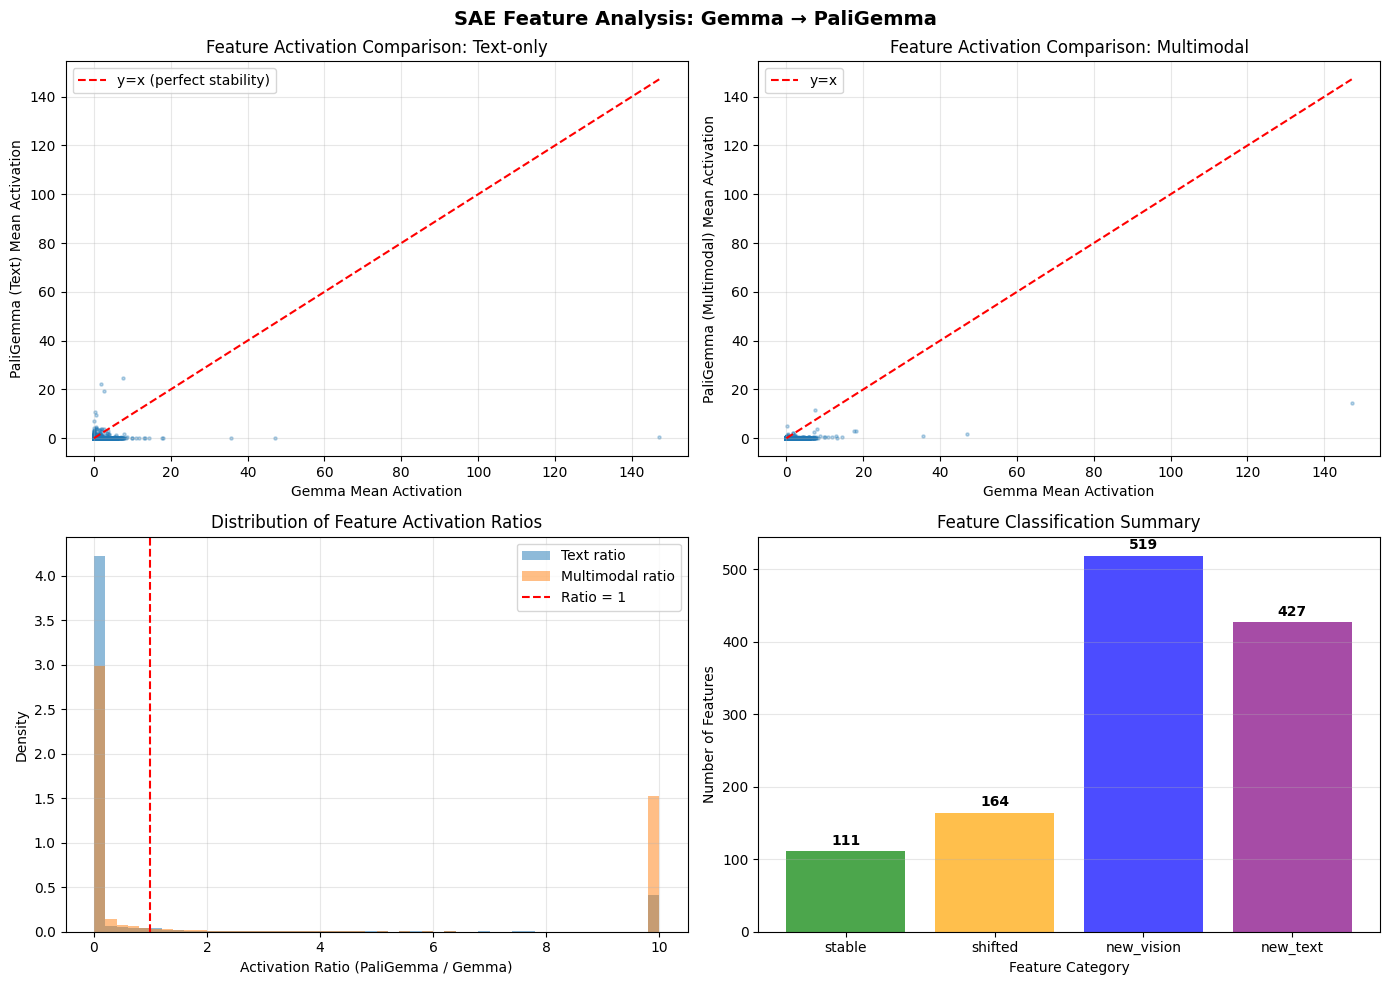

In [15]:
# ==========================================
# Cell 12: Feature Distribution Visualization
# ==========================================

# Ensure figures directory exists
os.makedirs("figures", exist_ok=True)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f"SAE Feature Analysis: {BASE_NAME} → {MM_NAME}", fontsize=14, fontweight='bold')

# Plot 1: Scatter plot of mean activations (Base vs MM text)
ax = axes[0, 0]
ax.scatter(base_mean.numpy(), mm_text_mean.numpy(), alpha=0.3, s=5)
ax.plot([0, base_mean.max()], [0, base_mean.max()], 'r--', label='y=x (perfect stability)')
ax.set_xlabel(f"{BASE_NAME} Mean Activation")
ax.set_ylabel(f"{MM_NAME} (Text) Mean Activation")
ax.set_title("Feature Activation Comparison: Text-only")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Scatter plot (Base vs MM multimodal)
ax = axes[0, 1]
ax.scatter(base_mean.numpy(), mm_full_mean.numpy(), alpha=0.3, s=5)
ax.plot([0, base_mean.max()], [0, base_mean.max()], 'r--', label='y=x')
ax.set_xlabel(f"{BASE_NAME} Mean Activation")
ax.set_ylabel(f"{MM_NAME} (Multimodal) Mean Activation")
ax.set_title("Feature Activation Comparison: Multimodal")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Distribution of feature activation ratios
ax = axes[1, 0]
# Avoid division by zero
eps = 1e-6
text_ratio = (mm_text_mean / (base_mean + eps)).numpy()
mm_ratio = (mm_full_mean / (base_mean + eps)).numpy()
# Clip for visualization
text_ratio = np.clip(text_ratio, 0, 10)
mm_ratio = np.clip(mm_ratio, 0, 10)

ax.hist(text_ratio, bins=50, alpha=0.5, label='Text ratio', density=True)
ax.hist(mm_ratio, bins=50, alpha=0.5, label='Multimodal ratio', density=True)
ax.axvline(x=1.0, color='r', linestyle='--', label='Ratio = 1')
ax.set_xlabel(f"Activation Ratio ({MM_NAME} / {BASE_NAME})")
ax.set_ylabel("Density")
ax.set_title("Distribution of Feature Activation Ratios")
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Feature category bar chart
ax = axes[1, 1]
categories = list(feature_classification.keys())
counts = [len(feature_classification[cat]) for cat in categories]
colors = ['green', 'orange', 'blue', 'purple']
bars = ax.bar(categories, counts, color=colors, alpha=0.7)
ax.set_xlabel("Feature Category")
ax.set_ylabel("Number of Features")
ax.set_title("Feature Classification Summary")
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            str(count), ha='center', va='bottom', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(f"figures/sae_feature_distribution_{MODEL_FAMILY}.svg", format='svg', bbox_inches='tight')
plt.savefig(f"figures/sae_feature_distribution_{MODEL_FAMILY}.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Detailed Feature Examples: Stable, Shifted, and New Features

Now we analyze 2-4 concrete examples from each category, showing:
- What tokens/images maximally activate each feature
- How activation patterns differ between base and multimodal models

In [16]:
# ==========================================
# Cell 13: Helper Functions for Feature Analysis
# ==========================================

# Get special tokens dynamically from tokenizers
def get_special_token_set(*tokenizers):
    """Get the union of all special tokens from the provided tokenizers."""
    special_tokens = set()
    for tokenizer in tokenizers:
        # Get all special tokens list
        if hasattr(tokenizer, 'all_special_tokens'):
            special_tokens.update(tokenizer.all_special_tokens)
        # Get special tokens from the map (values can be str or list)
        if hasattr(tokenizer, 'special_tokens_map'):
            for value in tokenizer.special_tokens_map.values():
                if isinstance(value, str):
                    special_tokens.add(value)
                elif isinstance(value, list):
                    special_tokens.update(value)
        # Also get special token IDs and convert them
        if hasattr(tokenizer, 'all_special_ids'):
            for token_id in tokenizer.all_special_ids:
                try:
                    special_tokens.add(tokenizer.decode([token_id]))
                except:
                    pass
    return special_tokens

# Build special tokens set from our loaded tokenizers
SPECIAL_TOKENS = get_special_token_set(base_tokenizer, mm_tokenizer)
print(f"Detected {len(SPECIAL_TOKENS)} special tokens: {SPECIAL_TOKENS}")


def is_meaningful_token(token: str, special_tokens: set = None) -> bool:
    """Check if a token is meaningful (not special token or whitespace-only).

    Args:
        token: The token string to check
        special_tokens: Set of special tokens to filter. Uses SPECIAL_TOKENS if None.
    """
    if special_tokens is None:
        special_tokens = SPECIAL_TOKENS

    token_stripped = token.strip()

    # Filter out empty/whitespace-only tokens
    if not token_stripped:
        return False

    # Filter out special tokens (check both stripped and original)
    if token_stripped in special_tokens or token in special_tokens:
        return False

    # Filter out tokens that are just whitespace variations
    if token.replace(' ', '').replace('\n', '').replace('\t', '') == '':
        return False

    return True


def get_top_activating_examples(
    feature_idx: int,
    features: torch.Tensor,
    tokens: List[str],
    top_k: int = 10,
    filter_special: bool = True
) -> List[Tuple[str, float]]:
    """Get the top-k tokens that maximally activate a feature.

    Args:
        feature_idx: Index of the feature to analyze
        features: Tensor of shape [num_tokens, num_features]
        tokens: List of token strings
        top_k: Number of top activating tokens to return
        filter_special: Whether to filter out special tokens and whitespace
    """
    feature_acts = features[:, feature_idx]

    # Sort all indices by activation (descending)
    sorted_indices = torch.argsort(feature_acts, descending=True)

    results = []
    for idx in sorted_indices:
        if idx >= len(tokens):
            continue
        token = tokens[idx.item()]

        # Filter special tokens if requested
        if filter_special and not is_meaningful_token(token):
            continue

        results.append((token, feature_acts[idx.item()].item()))

        if len(results) >= top_k:
            break

    return results


def analyze_single_feature(
    feature_idx: int,
    base_features: torch.Tensor,
    mm_text_features: torch.Tensor,
    mm_full_features: torch.Tensor,
    base_tokens: List[str],
    mm_tokens: List[str],
    category: str,
) -> Dict:
    """Analyze a single feature across all conditions."""

    # Get top activating tokens for each condition (filtering special tokens)
    base_top = get_top_activating_examples(feature_idx, base_features, base_tokens, filter_special=True)
    mm_text_top = get_top_activating_examples(feature_idx, mm_text_features, mm_tokens, filter_special=True)

    # Statistics
    b_mean = base_features[:, feature_idx].mean().item()
    b_max = base_features[:, feature_idx].max().item()
    m_text_mean = mm_text_features[:, feature_idx].mean().item()
    m_text_max = mm_text_features[:, feature_idx].max().item()
    m_mm_mean = mm_full_features[:, feature_idx].mean().item()
    m_mm_max = mm_full_features[:, feature_idx].max().item()

    return {
        "feature_idx": feature_idx,
        "category": category,
        "base_mean": b_mean,
        "base_max": b_max,
        "mm_text_mean": m_text_mean,
        "mm_text_max": m_text_max,
        "mm_full_mean": m_mm_mean,
        "mm_full_max": m_mm_max,
        "base_top_tokens": base_top[:5],
        "mm_text_top_tokens": mm_text_top[:5],
    }


def plot_feature_comparison(analysis: Dict, fig_num: int):
    """Create a detailed visualization for a single feature."""

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f"Feature #{analysis['feature_idx']} ({analysis['category'].upper()}) - {MODEL_FAMILY.upper()}",
                 fontsize=14, fontweight='bold')

    # Plot 1: Activation statistics bar chart
    ax = axes[0]
    conditions = [f'{BASE_NAME}\nText', f'{MM_NAME}\nText', f'{MM_NAME}\nMultimodal']
    means = [analysis['base_mean'], analysis['mm_text_mean'], analysis['mm_full_mean']]
    maxs = [analysis['base_max'], analysis['mm_text_max'], analysis['mm_full_max']]

    x = np.arange(len(conditions))
    width = 0.35
    bars1 = ax.bar(x - width/2, means, width, label='Mean', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, maxs, width, label='Max', color='coral', alpha=0.8)
    ax.set_ylabel('Activation')
    ax.set_xticks(x)
    ax.set_xticklabels(conditions)
    ax.legend()
    ax.set_title('Activation Statistics')
    ax.grid(True, alpha=0.3, axis='y')

    # Plot 2: Top activating tokens for base model
    ax = axes[1]
    base_tokens_display = [t[0][:20] for t in analysis['base_top_tokens']]
    base_acts = [t[1] for t in analysis['base_top_tokens']]
    if base_tokens_display:
        y_pos = np.arange(len(base_tokens_display))
        ax.barh(y_pos, base_acts, color='green', alpha=0.7)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(base_tokens_display, fontsize=9)
        ax.invert_yaxis()
    ax.set_xlabel('Activation')
    ax.set_title(f'Top Tokens ({BASE_NAME})')
    ax.grid(True, alpha=0.3, axis='x')

    # Plot 3: Top activating tokens for multimodal model
    ax = axes[2]
    mm_tokens_display = [t[0][:20] for t in analysis['mm_text_top_tokens']]
    mm_acts = [t[1] for t in analysis['mm_text_top_tokens']]
    if mm_tokens_display:
        y_pos = np.arange(len(mm_tokens_display))
        ax.barh(y_pos, mm_acts, color='purple', alpha=0.7)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(mm_tokens_display, fontsize=9)
        ax.invert_yaxis()
    ax.set_xlabel('Activation')
    ax.set_title(f'Top Tokens ({MM_NAME})')
    ax.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.savefig(f"figures/feature_{analysis['feature_idx']}_{analysis['category']}_{MODEL_FAMILY}.svg",
                format='svg', bbox_inches='tight')
    plt.show()


print("Feature analysis helper functions defined!")

Detected 7 special tokens: {'<start_of_turn>', '<eos>', '<bos>', '<end_of_turn>', '<unk>', '<pad>', '<image>'}
Feature analysis helper functions defined!


In [17]:
# ==========================================
# Cell 14: Analyze Example Features from Each Category
# ==========================================

# Create figures directory if it doesn't exist
os.makedirs("figures", exist_ok=True)

# Select top features from each category (by activity level)
def select_top_features(feature_indices: List[int], features: torch.Tensor, n: int = 4) -> List[int]:
    """Select the n most active features from a list."""
    if not feature_indices:
        return []
    feature_means = features[:, feature_indices].mean(dim=0)
    top_indices = torch.topk(feature_means, min(n, len(feature_indices))).indices
    return [feature_indices[i] for i in top_indices.tolist()]

# Get representative features from each category
example_features = {}
for category in ['stable', 'shifted', 'new_vision', 'new_text']:
    if category == 'new_vision':
        # Use multimodal features for selection
        example_features[category] = select_top_features(
            feature_classification[category], mm_full_features, n=4
        )
    elif category == 'new_text':
        example_features[category] = select_top_features(
            feature_classification[category], mm_text_features, n=4
        )
    else:
        example_features[category] = select_top_features(
            feature_classification[category], base_features, n=4
        )

print(f"Selected example features for detailed analysis ({MODEL_FAMILY.upper()}):")
for cat, feats in example_features.items():
    print(f"  {cat}: {feats}")

Selected example features for detailed analysis (GEMMA):
  stable: [15167, 15203, 12876, 833]
  shifted: [3031, 3910, 6639, 10324]
  new_vision: [3870, 6477, 1492, 7500]
  new_text: [1098, 402, 16074, 4587]


### Example 1: Stable Features

These features maintain similar activation patterns across both base and multimodal models, suggesting they encode concepts that transfer well to the multimodal setting.

STABLE FEATURES - Similar activation patterns across models

--- Stable Feature #15167 ---
  Gemma mean: 3.5664, max: 39.9302
  PaliGemma text mean: 3.0496, max: 32.3067
  PaliGemma multimodal mean: 0.1848
  Top Gemma tokens: [' the', ' the', ' the']
  Top PaliGemma tokens: [' the', ' the', ' the']


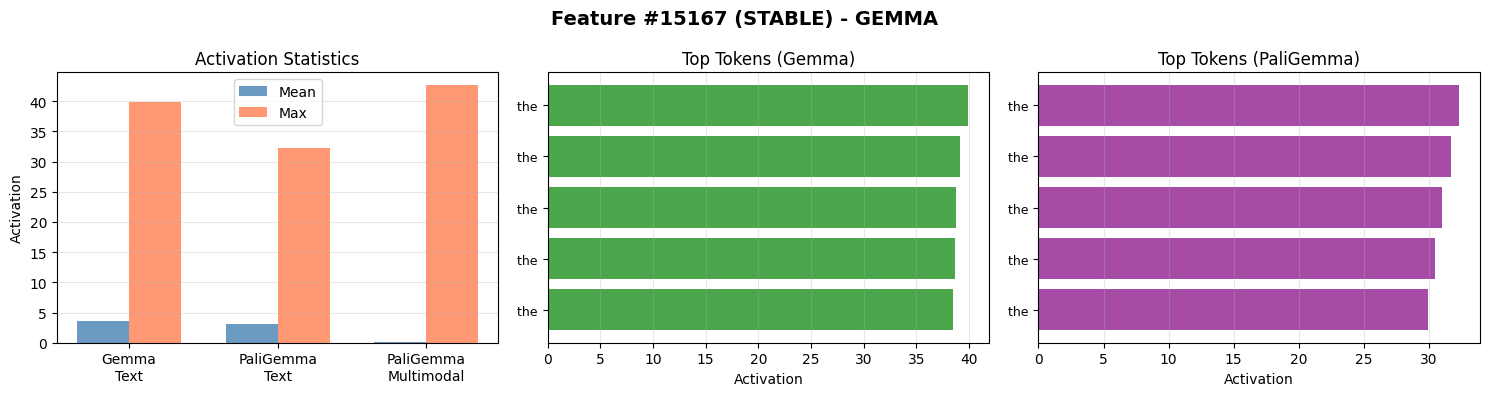


--- Stable Feature #15203 ---
  Gemma mean: 1.8608, max: 17.7078
  PaliGemma text mean: 1.8760, max: 12.7213
  PaliGemma multimodal mean: 1.2136
  Top Gemma tokens: [' mountains', ' ancient', ' love']
  Top PaliGemma tokens: ['Hello', ' apples', ' bounced']


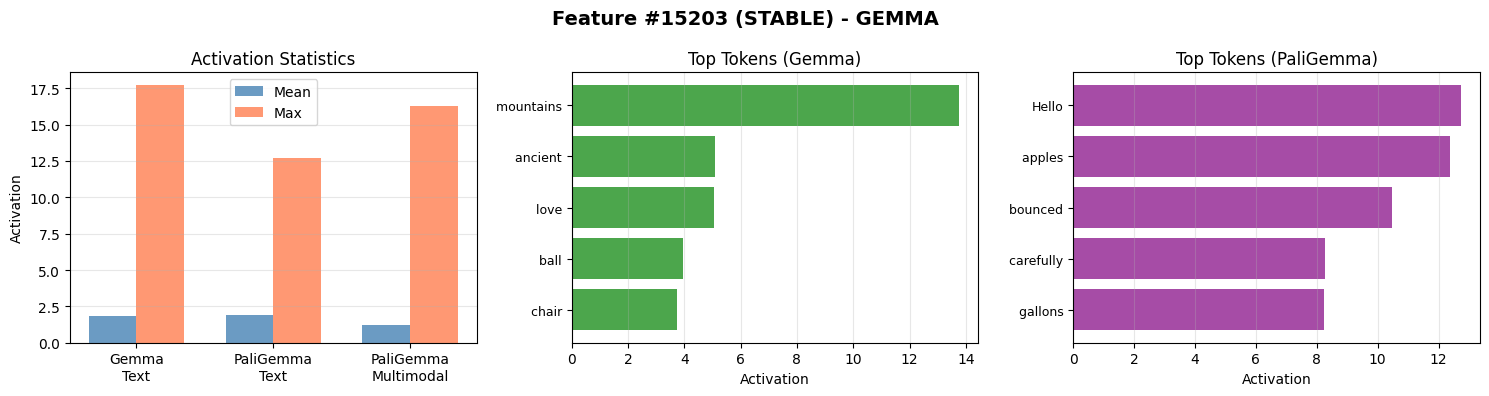


--- Stable Feature #12876 ---
  Gemma mean: 1.6810, max: 17.8719
  PaliGemma text mean: 1.2003, max: 6.2469
  PaliGemma multimodal mean: 0.0852
  Top Gemma tokens: [' ball', ' message', ' an']
  Top PaliGemma tokens: ['5', ' two', '3']


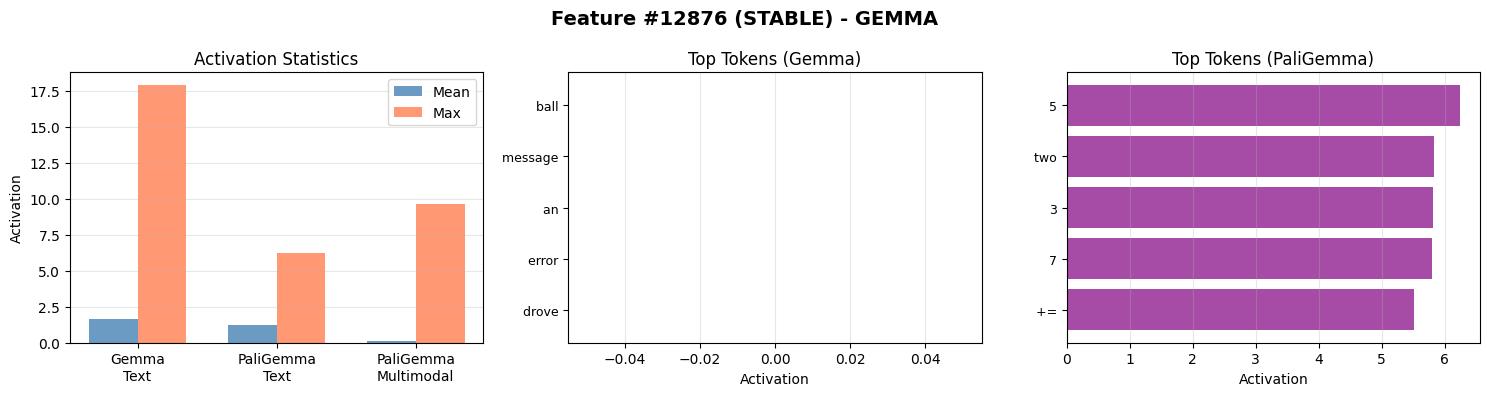


--- Stable Feature #833 ---
  Gemma mean: 1.6598, max: 14.3332
  PaliGemma text mean: 1.7466, max: 12.8470
  PaliGemma multimodal mean: 0.0638
  Top Gemma tokens: ['2', ' sum', ' print']
  Top PaliGemma tokens: [' hello', ' red', ' cat']


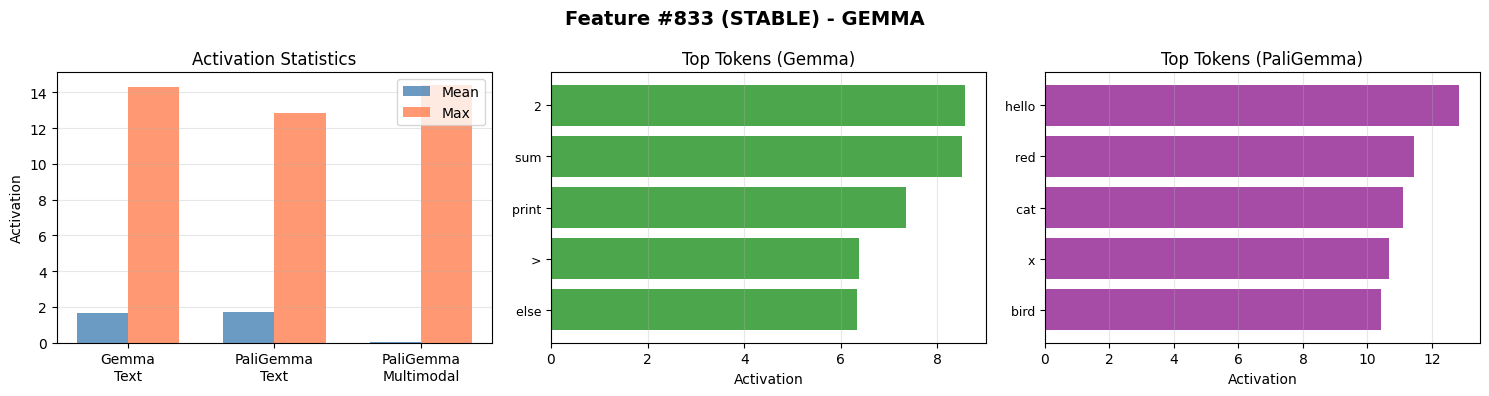

In [18]:
# ==========================================
# Cell 15: Analyze Stable Features
# ==========================================

print("=" * 60)
print("STABLE FEATURES - Similar activation patterns across models")
print("=" * 60)

stable_analyses = []
for i, feat_idx in enumerate(example_features.get('stable', [])[:4]):
    print(f"\n--- Stable Feature #{feat_idx} ---")
    analysis = analyze_single_feature(
        feat_idx, base_features, mm_text_features, mm_full_features,
        base_tokens, mm_text_tokens, "stable"
    )
    stable_analyses.append(analysis)

    print(f"  {BASE_NAME} mean: {analysis['base_mean']:.4f}, max: {analysis['base_max']:.4f}")
    print(f"  {MM_NAME} text mean: {analysis['mm_text_mean']:.4f}, max: {analysis['mm_text_max']:.4f}")
    print(f"  {MM_NAME} multimodal mean: {analysis['mm_full_mean']:.4f}")
    print(f"  Top {BASE_NAME} tokens: {[t[0] for t in analysis['base_top_tokens'][:3]]}")
    print(f"  Top {MM_NAME} tokens: {[t[0] for t in analysis['mm_text_top_tokens'][:3]]}")

    plot_feature_comparison(analysis, i)

### Example 2: Shifted Features

These features exist in both models but with different activation patterns - suggesting semantic adaptation during multimodal training.

SHIFTED FEATURES - Active in both but with different patterns

--- Shifted Feature #3031 ---
  Shift ratio (PaliGemma/Gemma): 3.29x
  Gemma mean: 7.5146
  PaliGemma text mean: 24.7531
  Top Gemma tokens: [' is', ' of', ' the']
  Top PaliGemma tokens: ['def', 'if', 'A']


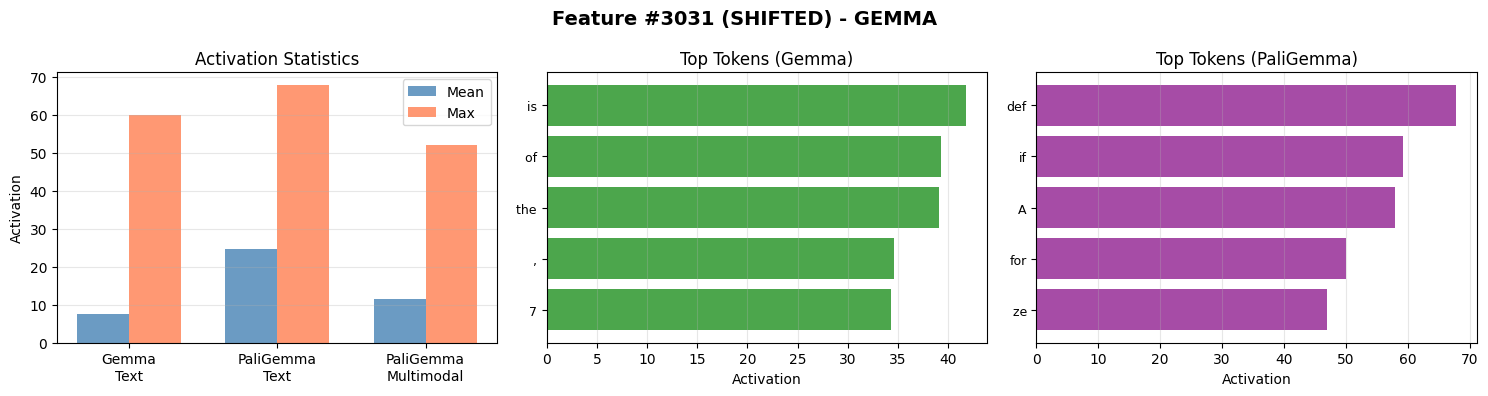


--- Shifted Feature #3910 ---
  Shift ratio (PaliGemma/Gemma): 0.37x
  Gemma mean: 4.0368
  PaliGemma text mean: 1.4806
  Top Gemma tokens: [':', ' high', ' kind']
  Top PaliGemma tokens: ['Hello', ' active', "('"]


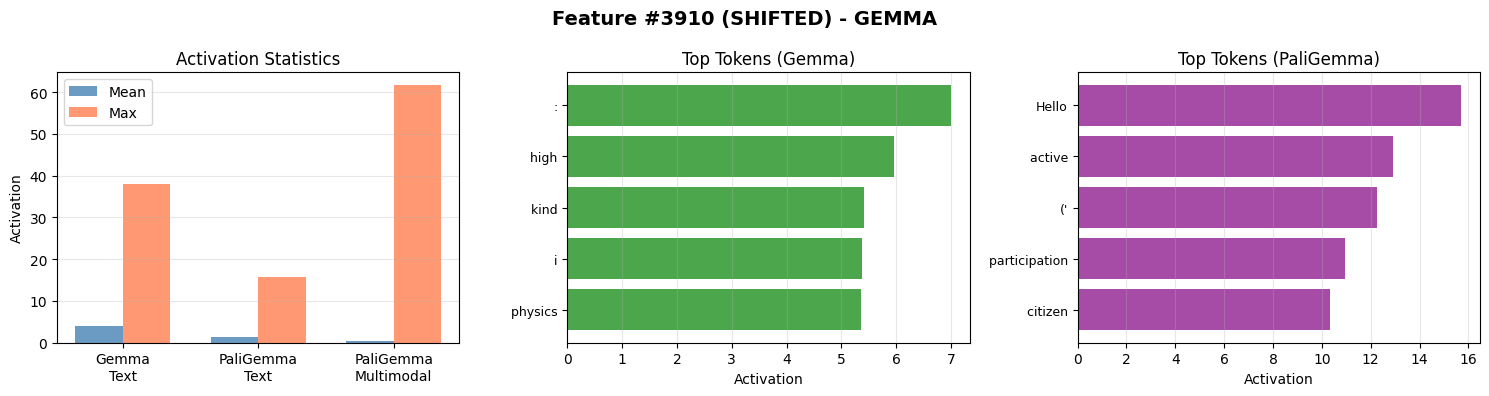


--- Shifted Feature #6639 ---
  Shift ratio (PaliGemma/Gemma): 0.41x
  Gemma mean: 4.0107
  PaliGemma text mean: 1.6500
  Top Gemma tokens: [' is', ' love', '8']
  Top PaliGemma tokens: [' beautiful', ' gracefully', ' answer']


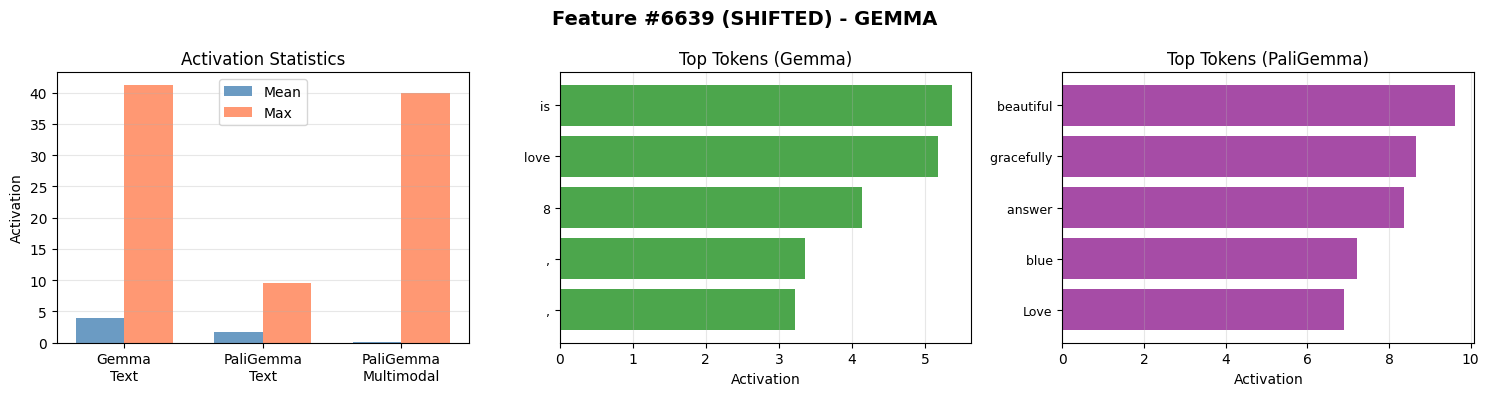


--- Shifted Feature #10324 ---
  Shift ratio (PaliGemma/Gemma): 0.50x
  Gemma mean: 3.7114
  PaliGemma text mean: 1.8491
  Top Gemma tokens: ['bras', ' participation', ' around']
  Top PaliGemma tokens: ['Democracy', ' active', ' requires']


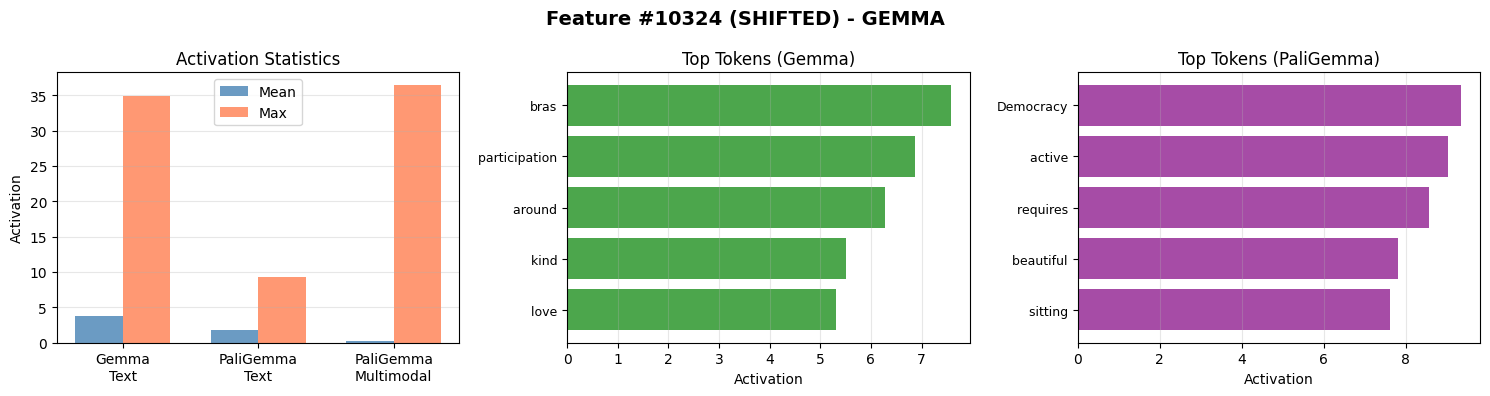

In [19]:
# ==========================================
# Cell 16: Analyze Shifted Features
# ==========================================

print("=" * 60)
print("SHIFTED FEATURES - Active in both but with different patterns")
print("=" * 60)

shifted_analyses = []
for i, feat_idx in enumerate(example_features.get('shifted', [])[:4]):
    print(f"\n--- Shifted Feature #{feat_idx} ---")
    analysis = analyze_single_feature(
        feat_idx, base_features, mm_text_features, mm_full_features,
        base_tokens, mm_text_tokens, "shifted"
    )
    shifted_analyses.append(analysis)

    # Calculate shift magnitude
    shift_ratio = analysis['mm_text_mean'] / (analysis['base_mean'] + 1e-6)
    print(f"  Shift ratio ({MM_NAME}/{BASE_NAME}): {shift_ratio:.2f}x")
    print(f"  {BASE_NAME} mean: {analysis['base_mean']:.4f}")
    print(f"  {MM_NAME} text mean: {analysis['mm_text_mean']:.4f}")
    print(f"  Top {BASE_NAME} tokens: {[t[0] for t in analysis['base_top_tokens'][:3]]}")
    print(f"  Top {MM_NAME} tokens: {[t[0] for t in analysis['mm_text_top_tokens'][:3]]}")

    plot_feature_comparison(analysis, i)

### Example 3: New Vision-Specific Features

These features are primarily active in PaliGemma when processing image inputs, suggesting they've been specialized for visual information.

NEW VISION-SPECIFIC FEATURES - Active mainly on image inputs

--- Vision-Specific Feature #3870 ---
  Vision boost: 29.48x over Gemma
  Text boost: 0.00x over Gemma
  Gemma mean: 0.0245
  PaliGemma multimodal mean: 0.7211


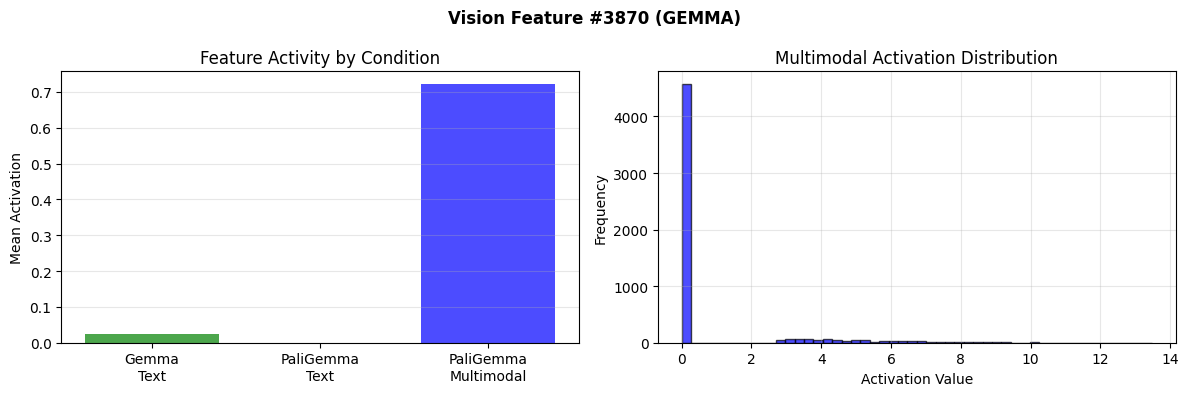


--- Vision-Specific Feature #6477 ---
  Vision boost: 47.44x over Gemma
  Text boost: 0.00x over Gemma
  Gemma mean: 0.0139
  PaliGemma multimodal mean: 0.6573


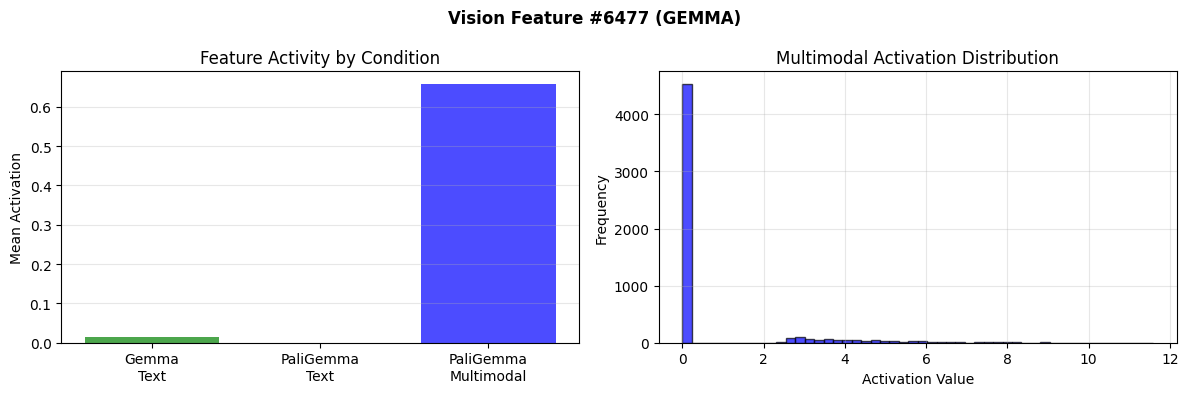


--- Vision-Specific Feature #1492 ---
  Vision boost: 45.43x over Gemma
  Text boost: 0.00x over Gemma
  Gemma mean: 0.0111
  PaliGemma multimodal mean: 0.5041


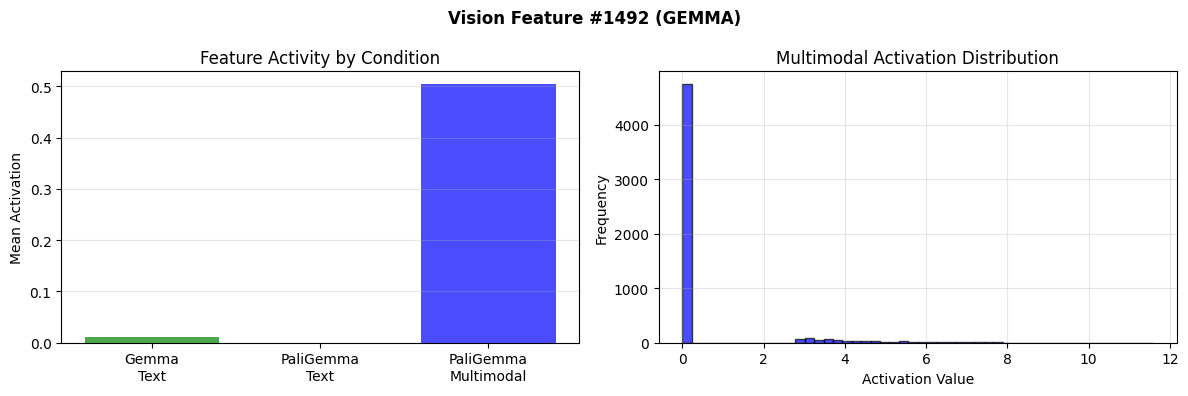


--- Vision-Specific Feature #7500 ---
  Vision boost: 496034.41x over Gemma
  Text boost: 0.00x over Gemma
  Gemma mean: 0.0000
  PaliGemma multimodal mean: 0.4960


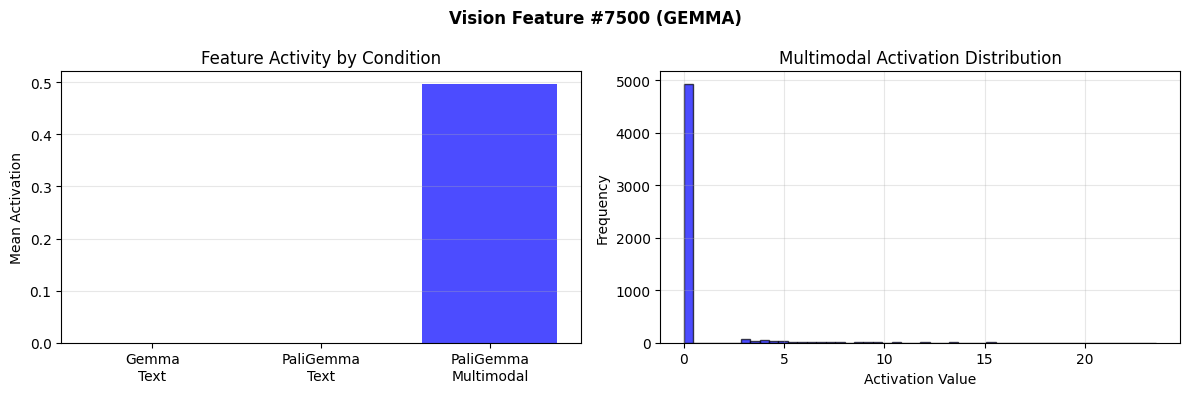

In [20]:
# ==========================================
# Cell 17: Analyze New Vision-Specific Features
# ==========================================

print("=" * 60)
print("NEW VISION-SPECIFIC FEATURES - Active mainly on image inputs")
print("=" * 60)

vision_analyses = []
for i, feat_idx in enumerate(example_features.get('new_vision', [])[:4]):
    print(f"\n--- Vision-Specific Feature #{feat_idx} ---")
    analysis = analyze_single_feature(
        feat_idx, base_features, mm_text_features, mm_full_features,
        base_tokens, mm_text_tokens, "new_vision"
    )
    vision_analyses.append(analysis)

    # Calculate vision specificity
    vision_ratio = analysis['mm_full_mean'] / (analysis['base_mean'] + 1e-6)
    text_ratio = analysis['mm_text_mean'] / (analysis['base_mean'] + 1e-6)
    print(f"  Vision boost: {vision_ratio:.2f}x over {BASE_NAME}")
    print(f"  Text boost: {text_ratio:.2f}x over {BASE_NAME}")
    print(f"  {BASE_NAME} mean: {analysis['base_mean']:.4f}")
    print(f"  {MM_NAME} multimodal mean: {analysis['mm_full_mean']:.4f}")

    # For vision features, show activation distribution across image positions
    feat_mm_acts = mm_full_features[:, feat_idx]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"Vision Feature #{feat_idx} ({MODEL_FAMILY.upper()})", fontsize=12, fontweight='bold')

    # Activation comparison across conditions
    ax = axes[0]
    conditions = [f'{BASE_NAME}\nText', f'{MM_NAME}\nText', f'{MM_NAME}\nMultimodal']
    means = [analysis['base_mean'], analysis['mm_text_mean'], analysis['mm_full_mean']]
    colors = ['green', 'purple', 'blue']
    bars = ax.bar(conditions, means, color=colors, alpha=0.7)
    ax.set_ylabel('Mean Activation')
    ax.set_title('Feature Activity by Condition')
    ax.grid(True, alpha=0.3, axis='y')

    # Histogram of multimodal activations
    ax = axes[1]
    ax.hist(feat_mm_acts.numpy(), bins=50, color='blue', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Activation Value')
    ax.set_ylabel('Frequency')
    ax.set_title('Multimodal Activation Distribution')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"figures/vision_feature_{feat_idx}_{MODEL_FAMILY}.svg", format='svg', bbox_inches='tight')
    plt.show()

## Summary Visualization: Feature Transfer Landscape

A comprehensive view of how SAE features transfer from the base model to the multimodal model.

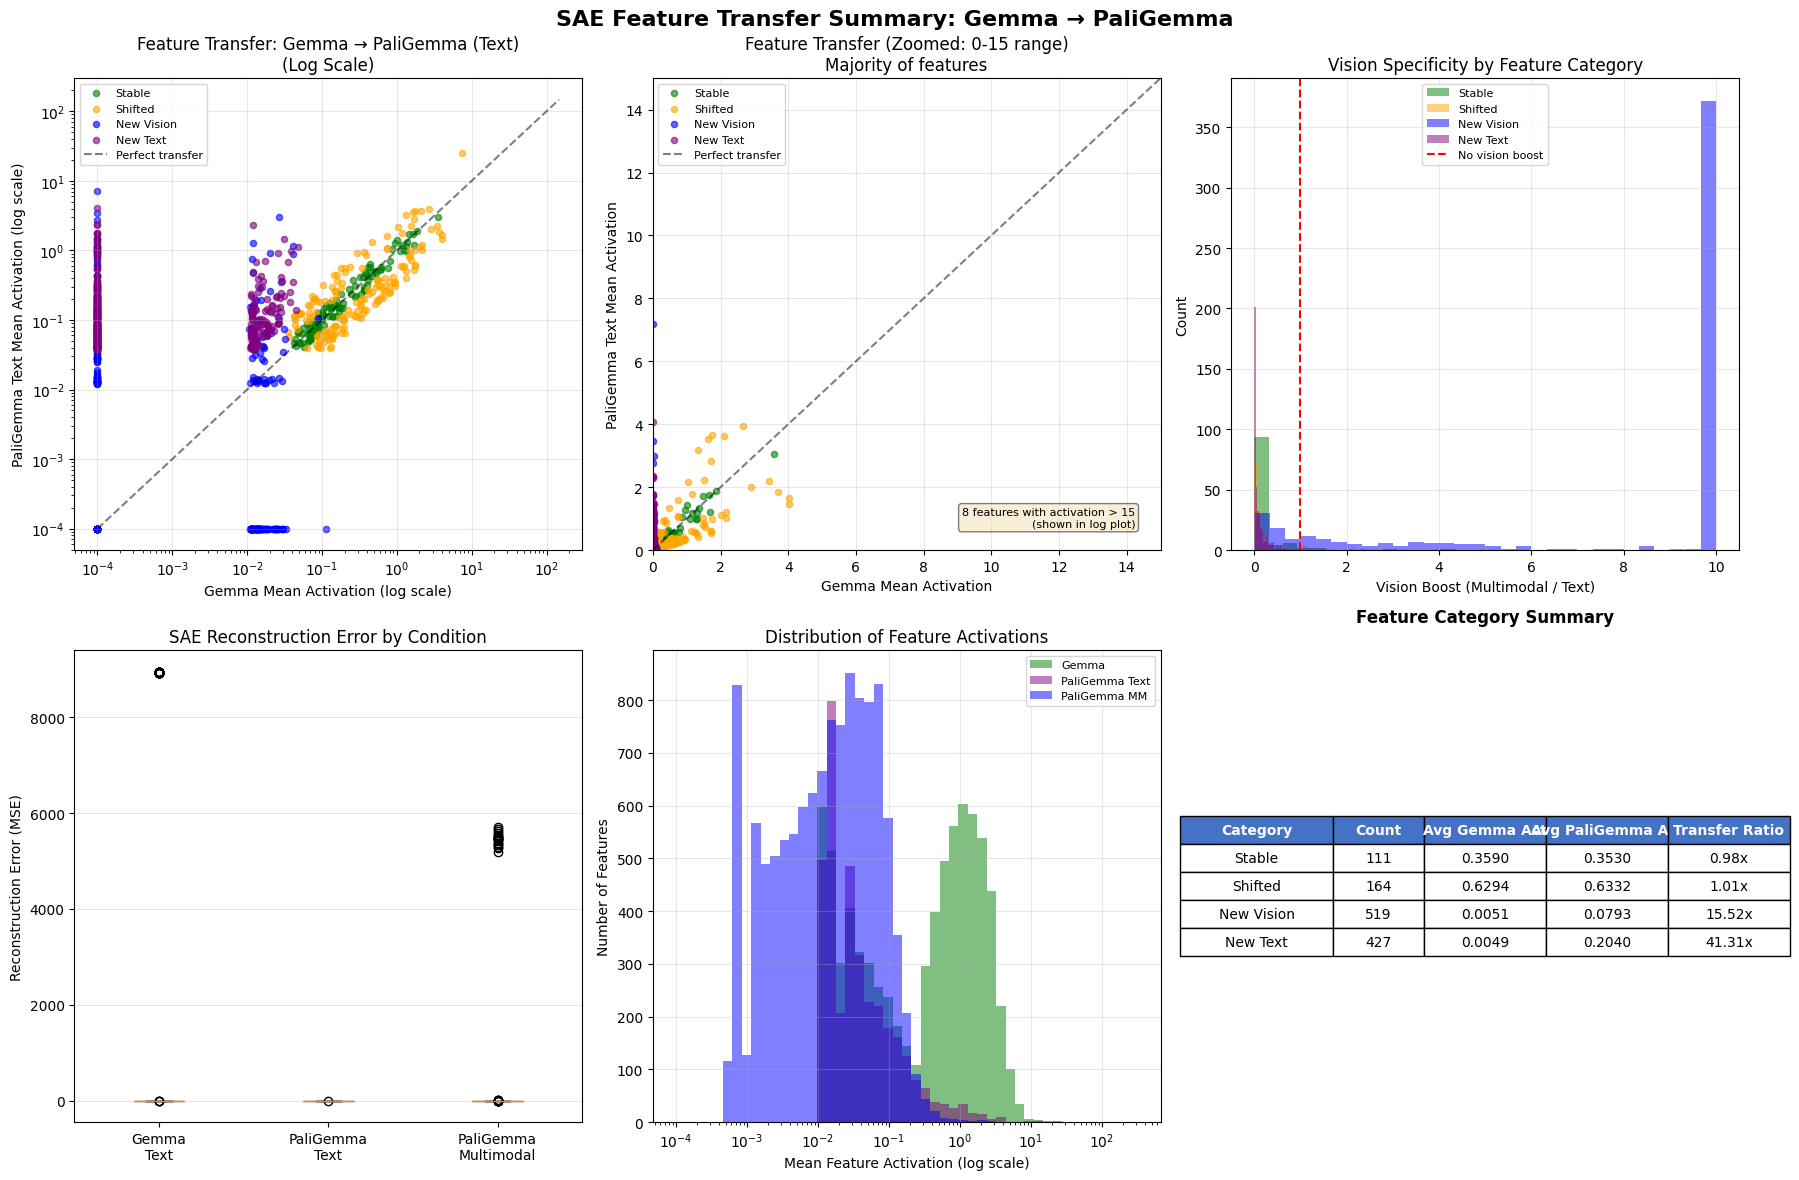


Summary saved to figures/sae_feature_transfer_summary_gemma.svg


In [21]:
# ==========================================
# Cell 18: Summary Visualization
# ==========================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f"SAE Feature Transfer Summary: {BASE_NAME} → {MM_NAME}", fontsize=16, fontweight='bold')

# Plot 1: 2D scatter of feature transfer (log scale for better visibility)
ax = axes[0, 0]
colors_map = {'stable': 'green', 'shifted': 'orange', 'new_vision': 'blue', 'new_text': 'purple'}
for category, feat_indices in feature_classification.items():
    if feat_indices:
        # Add small epsilon to avoid log(0)
        b_acts = base_mean[feat_indices].numpy() + 1e-4
        m_acts = mm_text_mean[feat_indices].numpy() + 1e-4
        ax.scatter(b_acts, m_acts, label=category.replace('_', ' ').title(),
                  color=colors_map[category], alpha=0.6, s=20)

# Diagonal line for perfect transfer
max_val = max(base_mean.max().item(), mm_text_mean.max().item())
ax.plot([1e-4, max_val], [1e-4, max_val], 'k--', alpha=0.5, label='Perfect transfer')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(f"{BASE_NAME} Mean Activation (log scale)")
ax.set_ylabel(f"{MM_NAME} Text Mean Activation (log scale)")
ax.set_title(f"Feature Transfer: {BASE_NAME} → {MM_NAME} (Text)\n(Log Scale)")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 2: Zoomed linear view (focus on main cluster)
ax = axes[0, 1]
for category, feat_indices in feature_classification.items():
    if feat_indices:
        b_acts = base_mean[feat_indices].numpy()
        m_acts = mm_text_mean[feat_indices].numpy()
        ax.scatter(b_acts, m_acts, label=category.replace('_', ' ').title(),
                  color=colors_map[category], alpha=0.6, s=20)

ax.plot([0, 15], [0, 15], 'k--', alpha=0.5, label='Perfect transfer')
ax.set_xlim(0, 15)
ax.set_ylim(0, 15)
ax.set_xlabel(f"{BASE_NAME} Mean Activation")
ax.set_ylabel(f"{MM_NAME} Text Mean Activation")
ax.set_title("Feature Transfer (Zoomed: 0-15 range)\nMajority of features")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Add annotation about outliers
n_outliers = ((base_mean > 15) | (mm_text_mean > 15)).sum().item()
ax.annotate(f'{n_outliers} features with activation > 15\n(shown in log plot)',
            xy=(0.95, 0.05), xycoords='axes fraction', ha='right', fontsize=8,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 3: Vision specificity analysis
ax = axes[0, 2]
vision_boost = (mm_full_mean / (mm_text_mean + 1e-6)).numpy()
vision_boost = np.clip(vision_boost, 0, 10)  # Clip for visualization

for category, feat_indices in feature_classification.items():
    if feat_indices:
        boosts = vision_boost[feat_indices]
        ax.hist(boosts, bins=30, alpha=0.5, label=category.replace('_', ' ').title(),
               color=colors_map[category])

ax.axvline(x=1.0, color='red', linestyle='--', label='No vision boost')
ax.set_xlabel("Vision Boost (Multimodal / Text)")
ax.set_ylabel("Count")
ax.set_title("Vision Specificity by Feature Category")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 4: Feature reconstruction error comparison
ax = axes[1, 0]
# Compute reconstruction errors for each model
# sae-lens SAE uses decode(encode(x)) for reconstruction
with torch.no_grad():
    # Move to device for SAE encoding/decoding
    base_flat_device = base_flat.to(DEVICE)
    mm_text_flat_device = mm_text_flat.to(DEVICE)
    mm_full_flat_device = mm_full_flat.to(DEVICE)

    base_recon = sae.decode(sae.encode(base_flat_device))
    mm_text_recon = sae.decode(sae.encode(mm_text_flat_device))
    mm_full_recon = sae.decode(sae.encode(mm_full_flat_device))

    base_error = F.mse_loss(base_recon, base_flat_device, reduction='none').mean(dim=1).cpu()
    mm_text_error = F.mse_loss(mm_text_recon, mm_text_flat_device, reduction='none').mean(dim=1).cpu()
    mm_full_error = F.mse_loss(mm_full_recon, mm_full_flat_device, reduction='none').mean(dim=1).cpu()

data = [base_error.numpy(), mm_text_error.numpy(), mm_full_error.numpy()]
labels = [f'{BASE_NAME}\nText', f'{MM_NAME}\nText', f'{MM_NAME}\nMultimodal']
bp = ax.boxplot(data, labels=labels, patch_artist=True)
colors_box = ['green', 'purple', 'blue']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax.set_ylabel("Reconstruction Error (MSE)")
ax.set_title("SAE Reconstruction Error by Condition")
ax.grid(True, alpha=0.3, axis='y')

# Plot 5: Activation distribution comparison (new plot)
ax = axes[1, 1]
# Show distribution of mean activations for each condition
bins = np.logspace(-4, 2.5, 50)  # Log-spaced bins
ax.hist(base_mean.numpy() + 1e-4, bins=bins, alpha=0.5, label=BASE_NAME, color='green')
ax.hist(mm_text_mean.numpy() + 1e-4, bins=bins, alpha=0.5, label=f'{MM_NAME} Text', color='purple')
ax.hist(mm_full_mean.numpy() + 1e-4, bins=bins, alpha=0.5, label=f'{MM_NAME} MM', color='blue')
ax.set_xscale('log')
ax.set_xlabel("Mean Feature Activation (log scale)")
ax.set_ylabel("Number of Features")
ax.set_title("Distribution of Feature Activations")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 6: Summary statistics table
ax = axes[1, 2]
ax.axis('off')

# Create summary table
summary_data = [
    ["Category", "Count", f"Avg {BASE_NAME} Act", f"Avg {MM_NAME} Act", "Transfer Ratio"],
]

for cat, indices in feature_classification.items():
    if indices:
        b_avg = base_mean[indices].mean().item()
        m_avg = mm_text_mean[indices].mean().item()
        ratio = m_avg / (b_avg + 1e-6)
        summary_data.append([
            cat.replace('_', ' ').title(),
            str(len(indices)),
            f"{b_avg:.4f}",
            f"{m_avg:.4f}",
            f"{ratio:.2f}x"
        ])

table = ax.table(
    cellText=summary_data,
    loc='center',
    cellLoc='center',
    colWidths=[0.25, 0.15, 0.2, 0.2, 0.2]
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# Make header row bold
for i in range(5):
    table[(0, i)].set_text_props(fontweight='bold')
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(color='white')

ax.set_title("Feature Category Summary", fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(f"figures/sae_feature_transfer_summary_{MODEL_FAMILY}.svg", format='svg', bbox_inches='tight')
plt.savefig(f"figures/sae_feature_transfer_summary_{MODEL_FAMILY}.pdf", format='pdf', bbox_inches='tight')
plt.show()

print(f"\nSummary saved to figures/sae_feature_transfer_summary_{MODEL_FAMILY}.svg")

## Conclusions

This experiment analyzed how SAE features transfer from a base language model to its multimodal variant:

### Key Findings:

1. **Stable Features**: Many features maintain similar activation patterns, suggesting core linguistic representations are preserved during multimodal training.

2. **Shifted Features**: Some features are active in both models but with different patterns - these may represent concepts that gain visual grounding or change meaning in the multimodal context.

3. **New Vision-Specific Features**: Features that activate primarily on image inputs suggest the model develops specialized representations for visual information.

### Implications for SAE Transfer:

- Reconstruction error alone is indeed too coarse - feature-level analysis reveals a more nuanced picture of how representations change.
- SAEs trained on base models can partially decode multimodal model representations, but vision-specific information requires different features.
- This analysis framework can guide decisions about when to retrain SAEs vs. adapt existing ones for multimodal models.

### Model Family Comparison:

This notebook supports both Gemma/PaliGemma and LLaMA/LLaVA families. Running with different `MODEL_FAMILY` settings allows comparing how different model architectures handle the base→multimodal transition.

In [22]:
# ==========================================
# Cell 19: Export Results Summary
# ==========================================

import pandas as pd

# Create a DataFrame with detailed feature analysis
results = []
for category, indices in feature_classification.items():
    for idx in indices[:50]:  # Limit to top 50 per category for export
        results.append({
            'model_family': MODEL_FAMILY,
            'base_model': BASE_NAME,
            'multimodal_model': MM_NAME,
            'feature_idx': idx,
            'category': category,
            'base_mean_activation': base_mean[idx].item(),
            'base_max_activation': base_max[idx].item(),
            'mm_text_mean': mm_text_mean[idx].item(),
            'mm_text_max': mm_text_max[idx].item(),
            'mm_full_mean': mm_full_mean[idx].item(),
            'mm_full_max': mm_full_max[idx].item(),
            'transfer_ratio': mm_text_mean[idx].item() / (base_mean[idx].item() + 1e-6),
            'vision_boost': mm_full_mean[idx].item() / (mm_text_mean[idx].item() + 1e-6),
        })

df = pd.DataFrame(results)
output_filename = f'sae_feature_analysis_results_{MODEL_FAMILY}.csv'
df.to_csv(output_filename, index=False)

print(f"Exported {len(results)} feature analyses to {output_filename}")
print(f"Model family: {MODEL_FAMILY.upper()} ({BASE_NAME} → {MM_NAME})")
print("\nSample results:")
display(df.head(10))

Exported 200 feature analyses to sae_feature_analysis_results_gemma.csv
Model family: GEMMA (Gemma → PaliGemma)

Sample results:


,model_family,base_model,multimodal_model,feature_idx,category,base_mean_activation,base_max_activation,mm_text_mean,mm_text_max,mm_full_mean,mm_full_max,transfer_ratio,vision_boost
0,gemma,Gemma,PaliGemma,90,stable,0.280031,5.760630,0.303965,5.706562,0.048055,8.477799,1.085467,0.158094
1,gemma,Gemma,PaliGemma,112,stable,0.085666,4.432683,0.069639,3.687261,0.045795,9.810381,0.812908,0.657589
2,gemma,Gemma,PaliGemma,274,stable,0.103435,12.780832,0.116560,4.492356,0.003649,4.450365,1.126885,0.031309
3,gemma,Gemma,PaliGemma,328,stable,0.323853,3.469087,0.412615,5.039689,0.005381,4.390407,1.274080,0.013042
4,gemma,Gemma,PaliGemma,337,stable,0.367507,6.357899,0.269296,5.372756,0.295925,7.670322,0.732764,1.098876
5,gemma,Gemma,PaliGemma,501,stable,0.048807,3.594688,0.047189,4.853338,0.059746,16.419893,0.966811,1.266095
6,gemma,Gemma,PaliGemma,810,stable,0.107367,9.725383,0.150559,11.608047,0.004195,12.228719,1.402276,0.027866
7,gemma,Gemma,PaliGemma,817,stable,0.769572,38.849369,0.565829,26.696259,0.061292,33.374790,0.735250,0.108323
8,gemma,Gemma,PaliGemma,833,stable,1.659824,14.333179,1.746599,12.847041,0.063769,14.407839,1.052279,0.036511
9,gemma,Gemma,PaliGemma,855,stable,0.463999,31.664682,0.430974,23.019909,0.000000,0.000000,0.928821,0.000000
